## Лабораторна робота №2

**Тема**: Глибинне Q-навчання, глибинна Q-мережа (DQN)

**Виконав:** студент групи КМ-12 Пономаренко Олександр

***Підгрупа №3***

Допустимі бібліотеки для реалізації лабораторної роботи:
- gym, gymnasium, ale-py - бібліотека з середовищами для навчання з підкріпленням;
- tensorflow, pytorch, keras - бібліотеки для створення, навчання і застосування нейронних мереж;
- numpy - бібліотека для математичних обчислень;
- matplotlib, seaborn - бібліотеки для побудови графіків.

In [364]:
# !pip install "gym[atari, accept-rom-license]"
# !pip install torch
# !pip install moviepy

Імпорти

In [369]:
import gym
import warnings
import os
import datetime
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

Додаткові налаштування

In [328]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
warnings.filterwarnings("ignore", category=DeprecationWarning)
torch._dynamo.config.suppress_errors = True
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

#### 0. Оберіть середовище із списку запропонованих:
- 3 підгрупа: <font color='red'>Blackjack</font>, <font color='green'>Pendulum</font>, <font color='blue'>Backgammon</font>, <font color='blue'>**MsPacman**</font>;

<font color='blue'>Такі середовища</font> є середовищами виду <font color='blue'><ins>[Atari 2600](https://ale.farama.org/environments/)</ins></font> бібліотеки ALE.

#### 1. Ознайомитись з описом середовища.

In [39]:
env = gym.make("ALE/MsPacman-v5", render_mode="human")

state, info = env.reset()
done = False

while not done:
    action = env.action_space.sample()
    state, reward, terminated, truncated, info = env.step(action)
    
    # Перевіряємо завершення гри
    if terminated or truncated:
        done = True

env.close()
print("Середовище закрито.")

env = gym.make("ALE/MsPacman-v5"); env.close()

Середовище закрито.


In [40]:
env = gym.make("ALE/MsPacman-v5")

In [41]:
print(f'Observation space: {env.observation_space}')
print(f'Action space: {env.action_space}')

Observation space: Box(0, 255, (210, 160, 3), uint8)
Action space: Discrete(9)


<img src="action_space.png" width="600" height="200">

#### 2. Реалізувати  агента  як  глибинну  Q-мережу  (DQN)  для  обраного середовища.

Можлива структура нейронної мережі:

- для <font color='blue'>середовищ</font> виду <font color='blue'><ins>[Atari 2600](https://ale.farama.org/environments/)</ins></font> використовуємо згорткову нейронну мережу:
    - вхідний шар складається з $K=1$ станів $(s_t, s_{t-1}, ..., s_{t-(K-1)})$, першим з яких є поточний стан середовища $s_t$. Один стан $s_j$ є зображенням кадром, на якому зображено поточний момент гри. Зображення початково перетворено у чорно-біле квадратне зображення розміром $84x84$.
    - Створюємо 4 прихованих шари:
        - І прихований шар є згортковим, має $32$ нейрони, кожен з яких є результатом застосування згорткового фільтру розміру $8х8$, що переміщується по початковому зображенню з кроком $stride=4$. До результату поелементно застосовується функція активації ReLU;
        - II прихований шар є згортковим, має $64$ нейрони, кожен з яких є результатом застосування згорткового фільтру розміру $4x4$, що переміщується по початковому зображенню з кроком $stride=2$. До результату поелементно застосовується функція активації ReLU;
        - III прихований шар є згортковим, має $64$ нейрони, кожен з яких є результатом застосування згорткового фільтру розміру $3x3$, що переміщується по початковому зображенню з кроком $stride=1$. До результату поелементно застосовується функція активації ReLU;
        - IV прихований шар є повністю з'єднаним (лінійним), має $512$ нейронів, функцією активації є ReLU;
    - Результатом застосування останнього прихованого шару є шар, кількість нейронів якого дорівнює кількості дій, вектор містить приблизні значення функції $Q(s_t, a)$.

Побудуємо згорткову нейронну мережу за описаною вище архітектурою:

In [468]:
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc = nn.Linear(7 * 7 * 64, 512)
        self.out = nn.Linear(512, n_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)   # переформатовуємо тензор, що ми отримали на вхід
                                    # з попереднього (згорткового шару). Першим значенням
                                    # вказуємо кількість вхідних прикладів (batch size), 
                                    # а другим - flatten значення з тензора
        
        x = F.relu(self.fc(x))      # виходом згорткового шару був тензор 
                                    # [batch_size, channels, height, width], а ми переформатували
                                    # його у [batch_size, channels * height * width], аби подати
                                    # коректний тензор на вхід у fully connected layer
        return self.out(x)

При ініціалізації класу для DQN ми вказали `super(DQN, self).__init__()`. Цей вираз викликає конструктор базового класу nn.Module. Таким чином, тепер для DQN ми зможемо використовувати всю необхідну внутрішню логіку PyTorch, яка дозволяє
- реєструвати параметри (weights, biases);
- задавати і використовувати forward prop;
- зберігати і завантажувати модель через методи `state_dict()` та `load_state_dict()` тощо.

Наступним кроком реалізуємо функцію для попередньої обробки кадрів, оскільки за умовою завдання зображення початково має бути перетворено у чорно-біле квадратне зображення розміром $84x84$:

In [287]:
# Попередня обробка кадрів
def preprocess_frame(frame):
    import cv2
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)           # Перетворення в ч/б (зменшуємо кількість
                                                              # каналів з трьох (RGB) до одного (grayscale) 
    frame = cv2.resize(frame, (84, 84))                       # Масштабування фрейму до розмірності 84х84
    frame = torch.tensor(frame, dtype=torch.float32) / 255.0  # Нормалізація grayscale значення для покращення
                                                              # стабільності навчання
    frame = frame.unsqueeze(0)                                # Додаємо новий вимір (канал), щоб тензор мав розмір
                                                              # [1, 84, 84] (необхідний формат для згорткових шарів)
    return frame

Ініціалізуємо побудовану мережу:

In [288]:
input_shape = (1, 84, 84)  # Один кадр
n_actions = env.action_space.n
net = DQN(input_shape, n_actions)

Перевіримо коректність значень, що повертаються мережею. Ми подали їй на вхід 1 кадр (batch_size=1) розмірністю 84х84 і очікуємо, що вона поверне значення функції ціни дії-стану для кожної можливої дії (9 штук) для поточного стану (того одного єдиного кадру, який ми передали через batch_size). 

In [289]:
test_input = torch.zeros((1, *input_shape))
test_output = net(test_input)
print(f"Output shape: {test_output.shape}")

Output shape: torch.Size([1, 9])


#### 3. Провести навчання агента при наступних значеннях гіперпараметрів:
- Кількість епох $Е$: будь-яке значення від $100$ до $500$;
- Кількість епізодів $М$ :
    - <font color='blue'>будь-яке значення від $1000$ до $5000$.</font>
- $\gamma = 0,99$;
- $\Delta\epsilon$: будь-яке значення від $0,9$ до $0,99999$;
- Оптимізатор цільової функції мережі - RMSProp або Adam.
- Швидкість навчання $\lambda$: будь-яке значення від $0,00001$ до $0,1$.

Після завершення навчання вивести графіки:
- середньої винагороди за весь епізод у кожній епосі (тобто графік функції $avg\_score(epoch)$);
- середнього значення $Q(s, a)$ на валідаційному епізоді кожної епохи;
- максимальне значення функції помилки на кожній епосі;

*Валідаційний епізод (held-out set) - це епізод, який відбуваєтсья після завершення однієї епохи навчання.*

In [329]:
def train_dqn_agent(env_name="ALE/MsPacman-v5", E=100, M=2000, gamma=0.99, epsilon_decay=0.995,
                    lr=0.0001, optimizer_type="Adam"):
    
    # Створення середовища
    env = gym.make(env_name)
    state_shape = (1, 84, 84)  # Грейскейл зображення 84x84
    num_actions = env.action_space.n
    
    # Ініціалізація агентів
    policy_net = DQN(state_shape, num_actions).to("cuda")
    
    optimizer = optim.Adam(policy_net.parameters(), lr=lr) if optimizer_type == "Adam" else optim.RMSprop(policy_net.parameters(), lr=lr)
    
    epsilon = 1.0
    rewards_per_epoch = []
    q_values_per_epoch = []
    max_losses_per_epoch = []
    
    for epoch in range(E):
        total_reward = 0
        losses = []
        q_values = []
        
        for episode in range(M // E):  # Ділимо на кількість епізодів в кожній епосі
            state, _ = env.reset()
            state = preprocess_frame(state)
            state = torch.FloatTensor(state).unsqueeze(0).to("cuda")
            done = False
            
            while not done:
                # Вибір дії
                if random.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    with torch.no_grad():
                        q_values_state = policy_net(state)
                        action = torch.argmax(q_values_state).item()
                
                # Виконання дії
                next_state, reward, terminated, truncated, _ = env.step(action)
                reward /= 100
                next_state = preprocess_frame(next_state)
                next_state = torch.FloatTensor(next_state).unsqueeze(0).to("cuda")
                
                # Обчислення Q-значень
                with torch.no_grad():
                    next_q_value = policy_net(next_state).max(1)[0].item()
                
                # Обмеження target_q_value
                target_q_value = reward + gamma * next_q_value * (1 - int(terminated or truncated))
                
                predicted_q_value = policy_net(state)[0, action]
                
                # Функція втрат
                loss = F.mse_loss(predicted_q_value, torch.tensor(target_q_value).to("cuda"))
                
                # Оновлення мережі
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # Збереження значень
                losses.append(loss.item())
                q_values.append(predicted_q_value.item())
                
                state = next_state
                total_reward += reward
                done = terminated or truncated
        
        # Зменшення epsilon
        epsilon = max(epsilon * epsilon_decay, 0.1)
        
        # Валідаційний епізод
        state, _ = env.reset()
        state = preprocess_frame(state)
        state = torch.FloatTensor(state).unsqueeze(0).to("cuda")
        done = False
        total_q_validation = 0
        steps = 0
        
        while not done:
            with torch.no_grad():
                q_values_validation = policy_net(state)
                total_q_validation += q_values_validation.max(1)[0].item()
                action = torch.argmax(q_values_validation).item()
            
            next_state, _, terminated, truncated, _ = env.step(action)
            next_state = preprocess_frame(next_state)
            next_state = torch.FloatTensor(next_state).unsqueeze(0).to("cuda")
            state = next_state
            done = terminated or truncated
            steps += 1
        
        avg_q_validation = total_q_validation / steps if steps > 0 else 0
        
        # Запис статистики
        max_loss = max(losses) if losses else 0
        rewards_per_epoch.append(total_reward / (M // E))
        q_values_per_epoch.append(avg_q_validation)
        max_losses_per_epoch.append(max_loss)
        
        print(f"Epoch {epoch+1}/{E}: Reward={rewards_per_epoch[-1]:.2f}, Avg Q-Validation={avg_q_validation:.2f}, Max Loss={max_loss:.4f}")
    
    # Збереження моделі
    model_save_path = "dqn_pacman.pth"
    torch.save(policy_net.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")
    
    # Графіки
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(rewards_per_epoch)
    plt.title("Average Reward per Epoch")
    
    plt.subplot(1, 3, 2)
    plt.plot(q_values_per_epoch)
    plt.title("Average Q-Value per Epoch (Validation)")
    
    plt.subplot(1, 3, 3)
    plt.plot(max_losses_per_epoch)
    plt.title("Max Loss per Epoch")
    
    plt.show()

    return policy_net

Epoch 1/100: Reward=2.21, Avg Q-Validation=2.30, Max Loss=33.1475
Epoch 2/100: Reward=2.46, Avg Q-Validation=2.13, Max Loss=10.6318
Epoch 3/100: Reward=2.69, Avg Q-Validation=1.76, Max Loss=9.5184
Epoch 4/100: Reward=4.49, Avg Q-Validation=1.29, Max Loss=53.6449
Epoch 5/100: Reward=3.89, Avg Q-Validation=1.88, Max Loss=20.9973
Epoch 6/100: Reward=4.76, Avg Q-Validation=1.87, Max Loss=15.9473
Epoch 7/100: Reward=5.26, Avg Q-Validation=2.28, Max Loss=7.3092
Epoch 8/100: Reward=5.08, Avg Q-Validation=1.76, Max Loss=21.4691
Epoch 9/100: Reward=5.15, Avg Q-Validation=2.10, Max Loss=5.1806
Epoch 10/100: Reward=7.37, Avg Q-Validation=3.37, Max Loss=17.8324
Epoch 11/100: Reward=5.36, Avg Q-Validation=1.33, Max Loss=7.0058
Epoch 12/100: Reward=5.56, Avg Q-Validation=1.01, Max Loss=9.9220
Epoch 13/100: Reward=6.02, Avg Q-Validation=2.53, Max Loss=20.0148
Epoch 14/100: Reward=7.75, Avg Q-Validation=2.79, Max Loss=15.8090
Epoch 15/100: Reward=6.16, Avg Q-Validation=1.35, Max Loss=10.7293
Epoch 16/

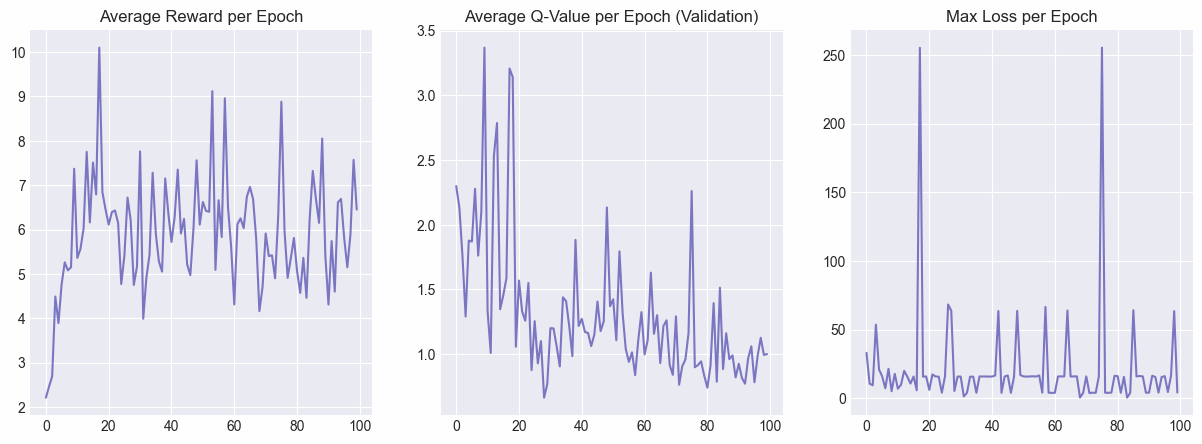

In [330]:
# Завершення навчання
trained_policy_net = train_dqn_agent(E=100, M=1000, gamma=0.99, epsilon_decay=0.9, lr=0.00001, optimizer_type="Adam")

#### 4. Провести тестування агента, провівши $100$ епізодів. Виведіть на екран два графіки: винагорода та тривалість епізоду. Також для епізодів $№№$ $1$, $randint(1, 100)$ та 100 виведіть два графіки: значення функції $Q(s, a)$ протягом кожного кроку, та графік винагороди (score), отриманої на кожному кроці епізоду.

In [331]:
def test_dqn_agent(model_path, env_name="ALE/MsPacman-v5", num_episodes=100):
    # Завантаження середовища
    env = gym.make(env_name)
    state_shape = (1, 84, 84)  # Грейскейл зображення 84x84
    num_actions = env.action_space.n

    # Завантаження моделі
    policy_net = DQN(state_shape, num_actions).to("cuda")
    policy_net.load_state_dict(torch.load(model_path, weights_only=True))
    policy_net.eval()

    rewards = []
    episode_lengths = []

    q_values_data = {}  # Для збереження Q-значень
    scores_data = {}  # Для збереження сумарних винагород (score per step)

    random_episode = random.randint(1, num_episodes)

    for episode in range(1, num_episodes + 1):
        state, _ = env.reset()
        state = preprocess_frame(state)
        state = torch.FloatTensor(state).unsqueeze(0).to("cuda")
        done = False

        episode_reward = 0
        episode_length = 0
        q_values_per_step = []
        scores_per_step = []

        while not done:
            with torch.no_grad():
                q_values_state = policy_net(state)
                action = torch.argmax(q_values_state).item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = preprocess_frame(next_state)
            next_state = torch.FloatTensor(next_state).unsqueeze(0).to("cuda")

            # Збереження Q-значень та сумарної винагороди (score)
            episode_reward += reward
            q_values_per_step.append(q_values_state.max(1)[0].item())
            scores_per_step.append(episode_reward)

            state = next_state
            episode_length += 1
            done = terminated or truncated

        rewards.append(episode_reward)
        episode_lengths.append(episode_length)

        # Збереження даних для епізодів 1, random_episode, 100
        if episode in {1, random_episode, num_episodes}:
            q_values_data[episode] = q_values_per_step
            scores_data[episode] = scores_per_step

    # Графіки винагороди та тривалості епізодів
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(rewards, label="Reward")
    plt.title("Rewards per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Reward")

    plt.subplot(1, 2, 2)
    plt.plot(episode_lengths, label="Episode Length")
    plt.title("Episode Length per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Length")

    plt.tight_layout()
    plt.show()

    # Графіки Q-Values і Score для епізодів 1, random_episode, 100
    for episode in [1, random_episode, num_episodes]:
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(q_values_data[episode], label=f"Episode {episode} Q-Values")
        plt.title(f"Q-Values per Step (Episode {episode})")
        plt.xlabel("Step")
        plt.ylabel("Q-Value")

        plt.subplot(1, 2, 2)
        plt.plot(scores_data[episode], label=f"Episode {episode} Score")
        plt.title(f"Scores per Step (Episode {episode})")
        plt.xlabel("Step")
        plt.ylabel("Score")

        plt.tight_layout()
        plt.show()

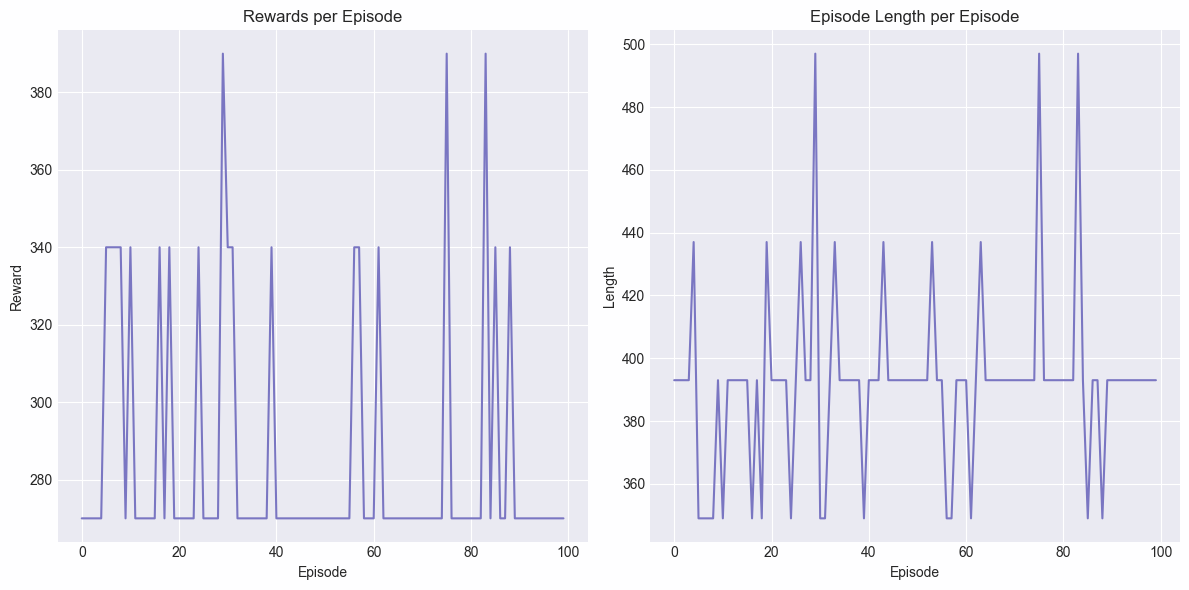

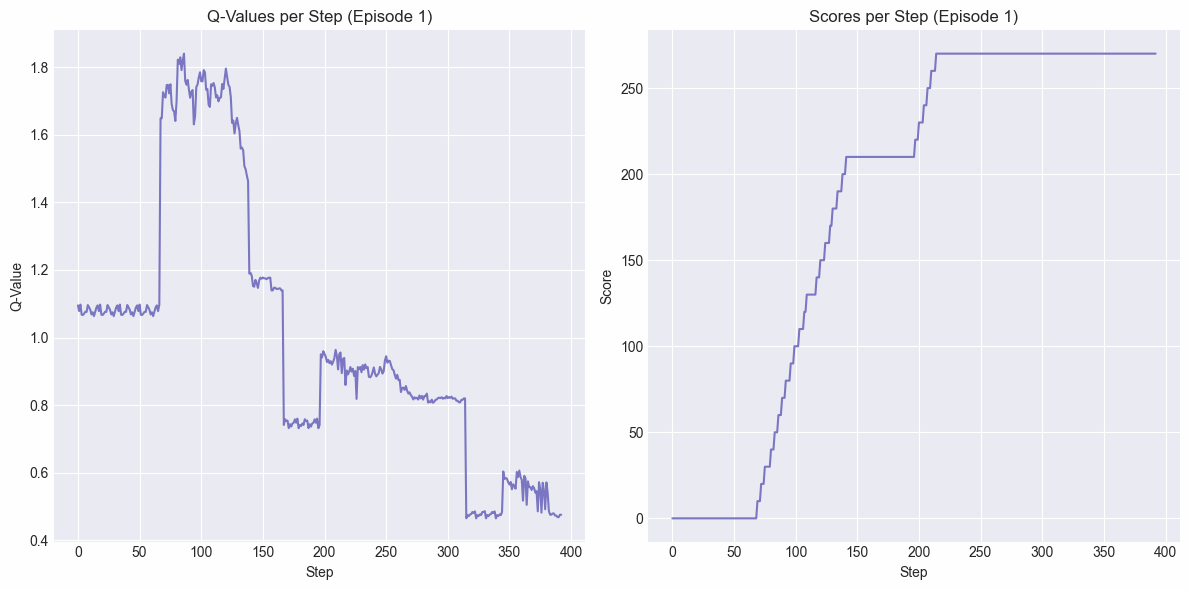

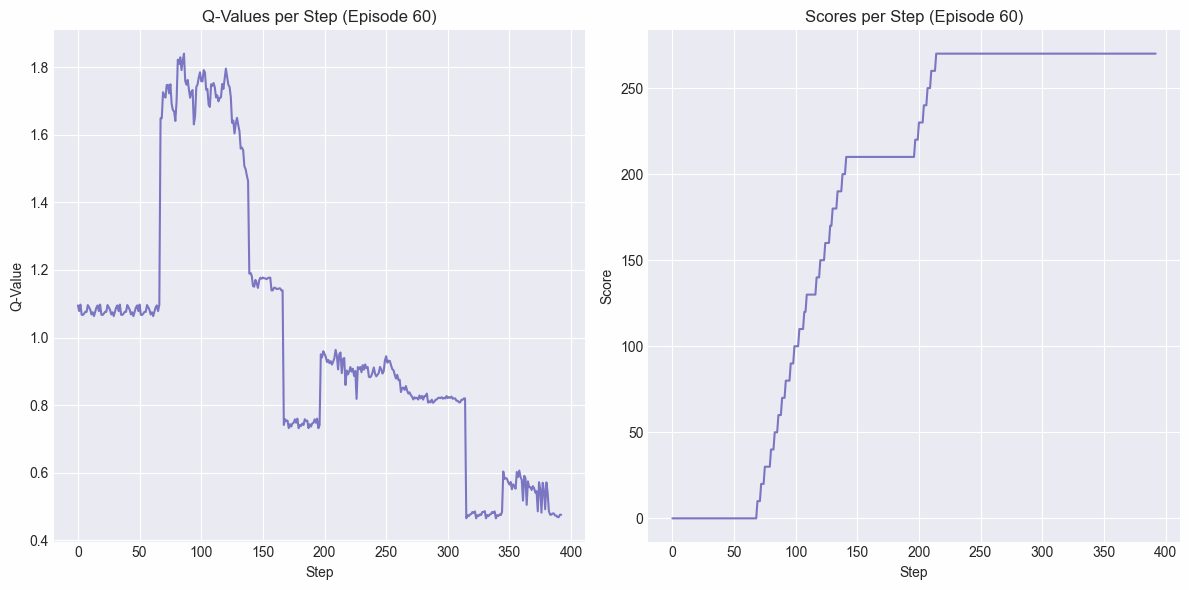

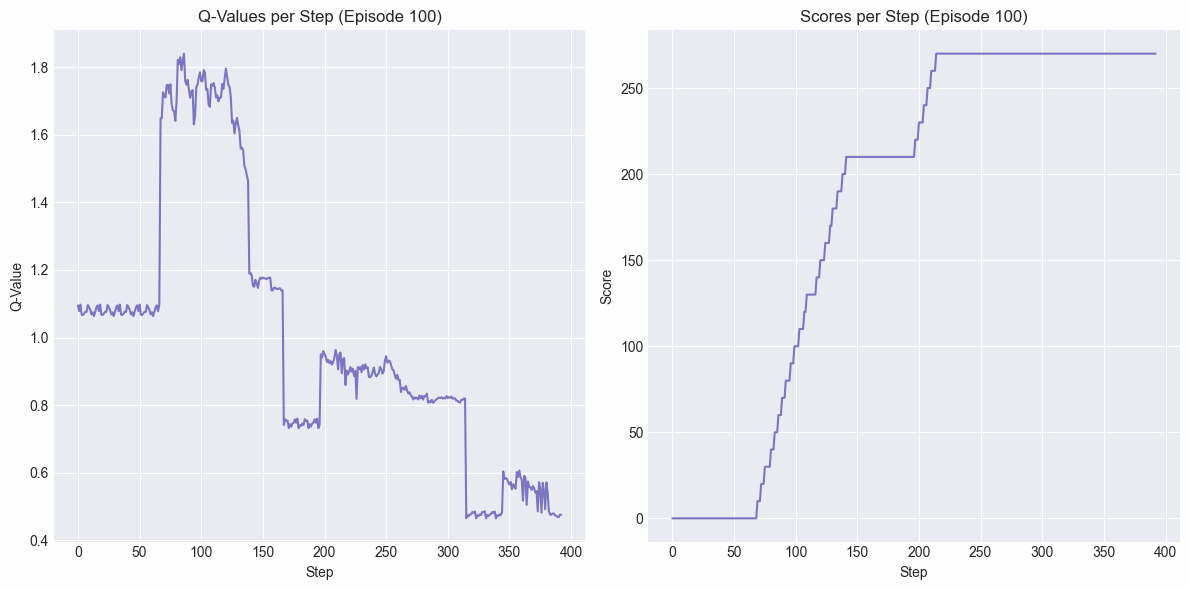

In [335]:
# Виклик функції тестування
test_dqn_agent("dqn_pacman.pth", num_episodes=100)

#### 5. Реалізувати глибинну Q-мережу (DQN) з фіксованою цільовою мережею (Fixed targets, FT). Назвемо цю мережу DQN-FT.

In [336]:
def train_dqn_ft_agent(env_name="ALE/MsPacman-v5", E=100, M=2000, gamma=0.99, epsilon_decay=0.995,
                       lr=0.0001, optimizer_type="Adam"):
    # Створення середовища
    env = gym.make(env_name)
    state_shape = (1, 84, 84)  # Грейскейл зображення 84x84
    num_actions = env.action_space.n

    # Ініціалізація політики та цільової мережі
    policy_net = DQN(state_shape, num_actions).to("cuda")
    target_net = DQN(state_shape, num_actions).to("cuda")
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=lr) if optimizer_type == "Adam" else optim.RMSprop(policy_net.parameters(), lr=lr)

    epsilon = 1.0
    rewards_per_epoch = []
    q_values_per_epoch = []
    max_losses_per_epoch = []

    for epoch in range(E):
        total_reward = 0
        losses = []
        q_values = []

        for episode in range(M // E):
            state, _ = env.reset()
            state = preprocess_frame(state)
            state = torch.FloatTensor(state).unsqueeze(0).to("cuda")
            done = False

            while not done:
                # Вибір дії
                if random.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    with torch.no_grad():
                        q_values_state = policy_net(state)
                        action = torch.argmax(q_values_state).item()

                # Виконання дії
                next_state, reward, terminated, truncated, _ = env.step(action)
                reward /= 100
                next_state = preprocess_frame(next_state)
                next_state = torch.FloatTensor(next_state).unsqueeze(0).to("cuda")

                # Обчислення Q-значень з використанням target_net
                with torch.no_grad():
                    next_q_value = target_net(next_state).max(1)[0].item()

                target_q_value = reward + gamma * next_q_value * (1 - int(terminated or truncated))
                predicted_q_value = policy_net(state)[0, action]

                # Функція втрат
                loss = F.mse_loss(predicted_q_value, torch.tensor(target_q_value).to("cuda"))

                # Оновлення політики
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Збереження значень
                losses.append(loss.item())
                q_values.append(predicted_q_value.item())

                state = next_state
                total_reward += reward
                done = terminated or truncated

        # Оновлення параметрів target_net
        target_net.load_state_dict(policy_net.state_dict())

        # Зменшення epsilon
        epsilon = max(epsilon * epsilon_decay, 0.1)

        # Валідаційний епізод
        state, _ = env.reset()
        state = preprocess_frame(state)
        state = torch.FloatTensor(state).unsqueeze(0).to("cuda")
        done = False
        total_q_validation = 0
        steps = 0

        while not done:
            with torch.no_grad():
                q_values_validation = policy_net(state)
                total_q_validation += q_values_validation.max(1)[0].item()
                action = torch.argmax(q_values_validation).item()

            next_state, _, terminated, truncated, _ = env.step(action)
            next_state = preprocess_frame(next_state)
            next_state = torch.FloatTensor(next_state).unsqueeze(0).to("cuda")
            state = next_state
            done = terminated or truncated
            steps += 1

        avg_q_validation = total_q_validation / steps if steps > 0 else 0

        # Запис статистики
        max_loss = max(losses) if losses else 0
        rewards_per_epoch.append(total_reward / (M // E))
        q_values_per_epoch.append(avg_q_validation)
        max_losses_per_epoch.append(max_loss)

        print(f"Epoch {epoch+1}/{E}: Reward={rewards_per_epoch[-1]:.2f}, Avg Q-Validation={avg_q_validation:.2f}, Max Loss={max_loss:.4f}")

    # Збереження моделі
    model_save_path = "dqn_ft_pacman.pth"
    torch.save(policy_net.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

    # Графіки
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(rewards_per_epoch)
    plt.title("Average Reward per Epoch")

    plt.subplot(1, 3, 2)
    plt.plot(q_values_per_epoch)
    plt.title("Average Q-Value per Epoch (Validation)")

    plt.subplot(1, 3, 3)
    plt.plot(max_losses_per_epoch)
    plt.title("Max Loss per Epoch")

    plt.show()

    return policy_net

Epoch 1/100: Reward=2.46, Avg Q-Validation=0.03, Max Loss=3.9747
Epoch 2/100: Reward=3.37, Avg Q-Validation=0.05, Max Loss=4.3516
Epoch 3/100: Reward=2.42, Avg Q-Validation=0.05, Max Loss=0.0115
Epoch 4/100: Reward=3.26, Avg Q-Validation=0.05, Max Loss=4.0061
Epoch 5/100: Reward=6.23, Avg Q-Validation=0.06, Max Loss=62.7749
Epoch 6/100: Reward=6.25, Avg Q-Validation=0.07, Max Loss=63.0868
Epoch 7/100: Reward=4.86, Avg Q-Validation=0.08, Max Loss=15.7751
Epoch 8/100: Reward=5.30, Avg Q-Validation=0.09, Max Loss=15.6689
Epoch 9/100: Reward=5.68, Avg Q-Validation=0.10, Max Loss=15.8420
Epoch 10/100: Reward=6.18, Avg Q-Validation=0.10, Max Loss=15.7556
Epoch 11/100: Reward=7.93, Avg Q-Validation=0.10, Max Loss=63.0233
Epoch 12/100: Reward=5.72, Avg Q-Validation=0.10, Max Loss=4.0055
Epoch 13/100: Reward=5.26, Avg Q-Validation=0.11, Max Loss=15.8977
Epoch 14/100: Reward=4.73, Avg Q-Validation=0.12, Max Loss=3.9924
Epoch 15/100: Reward=7.69, Avg Q-Validation=0.13, Max Loss=15.8162
Epoch 16/1

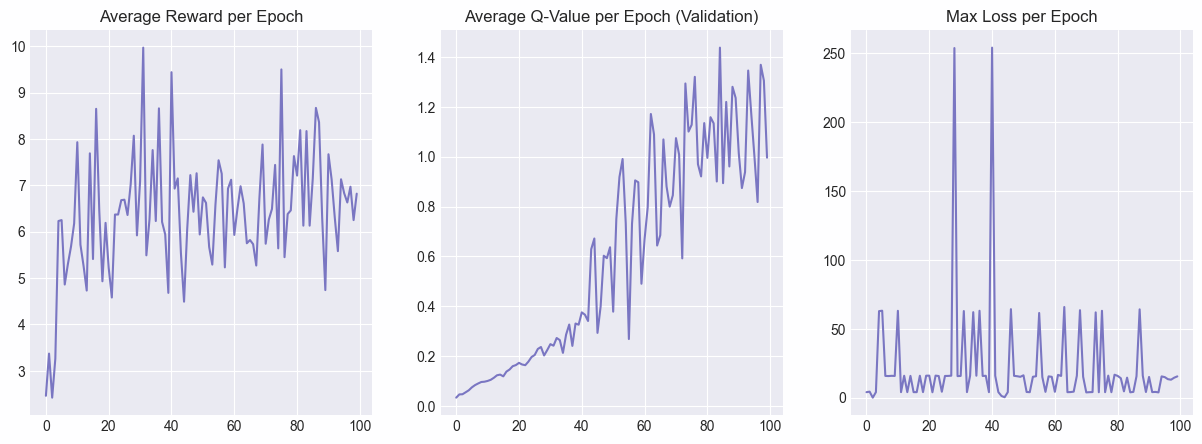

In [337]:
trained_policy_net_ft  = train_dqn_ft_agent(E=100, M=1000, gamma=0.99, epsilon_decay=0.9, lr=0.00001, optimizer_type="Adam")

#### 6. Повторити завдання 3, 4 для мережі DQN-FT. Порівняйте отримані результати з відповідними результатами 3, 4 та зробіть висновки. Для навчання використати наступні гіперпараметри, пов'язані з цільовою мережею:
- #### частота оновлення параметрів цільової мережі $C = N_e$.

In [ ]:
def test_dqn_ft_agent(model_path, env_name="ALE/MsPacman-v5", num_episodes=100):
    # Завантаження середовища
    env = gym.make(env_name)
    state_shape = (1, 84, 84)
    num_actions = env.action_space.n

    # Ініціалізація політики
    policy_net = DQN(state_shape, num_actions).to("cuda")
    policy_net.load_state_dict(torch.load(model_path, weights_only=True))
    policy_net.eval()

    episode_rewards = []
    episode_lengths = []

    q_values_data = {}
    scores_data = {}

    random_episode = random.randint(1, num_episodes)

    for episode in range(1, num_episodes + 1):
        state, _ = env.reset()
        state = preprocess_frame(state)
        state = torch.FloatTensor(state).unsqueeze(0).to("cuda")
        done = False

        total_reward = 0
        steps = 0

        q_values = []
        scores = []

        while not done:
            with torch.no_grad():
                q_values_state = policy_net(state)
                action = torch.argmax(q_values_state).item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward

            q_values.append(q_values_state.max(1)[0].item())
            scores.append(total_reward)

            next_state = preprocess_frame(next_state)
            state = torch.FloatTensor(next_state).unsqueeze(0).to("cuda")

            done = terminated or truncated
            steps += 1

        episode_rewards.append(total_reward)
        episode_lengths.append(steps)

        # Збереження даних для епізодів 1, random_episode, 100
        if episode in {1, random_episode, num_episodes}:
            q_values_data[episode] = q_values
            scores_data[episode] = scores

    # Графіки винагород і тривалості епізодів
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(episode_rewards)
    plt.title("Rewards per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Reward")

    plt.subplot(1, 2, 2)
    plt.plot(episode_lengths)
    plt.title("Episode Lengths")
    plt.xlabel("Episode")
    plt.ylabel("Steps")

    plt.tight_layout()
    plt.show()

    # Графіки Q-Values і Score для епізодів 1, random_episode, 100
    for episode in [1, random_episode, num_episodes]:
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(q_values_data[episode])
        plt.title(f"Q-Values per Step (Episode {episode})")
        plt.xlabel("Step")
        plt.ylabel("Q-Value")

        plt.subplot(1, 2, 2)
        plt.plot(scores_data[episode])
        plt.title(f"Score per Step (Episode {episode})")
        plt.xlabel("Step")
        plt.ylabel("Score")

        plt.tight_layout()
        plt.show()

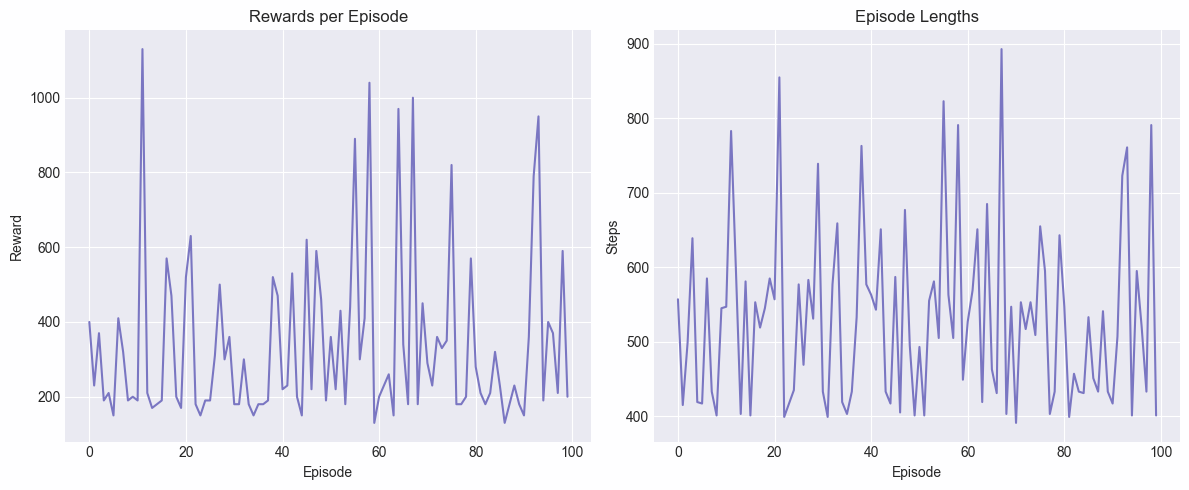

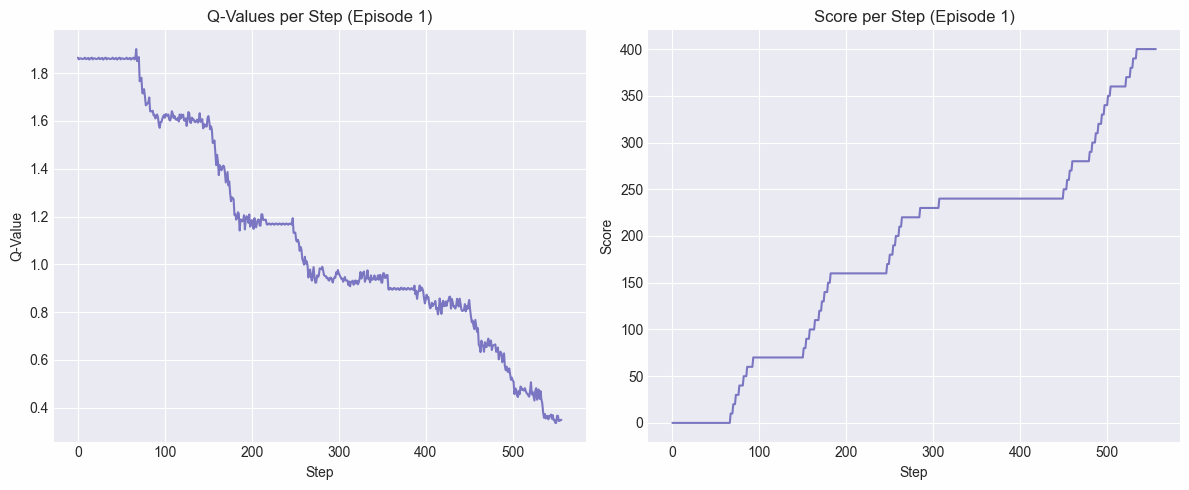

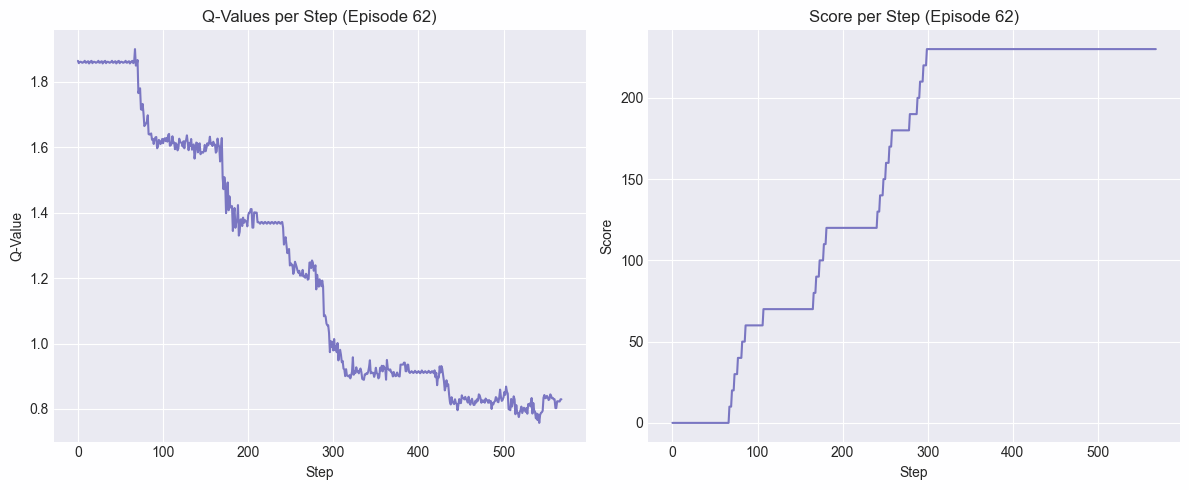

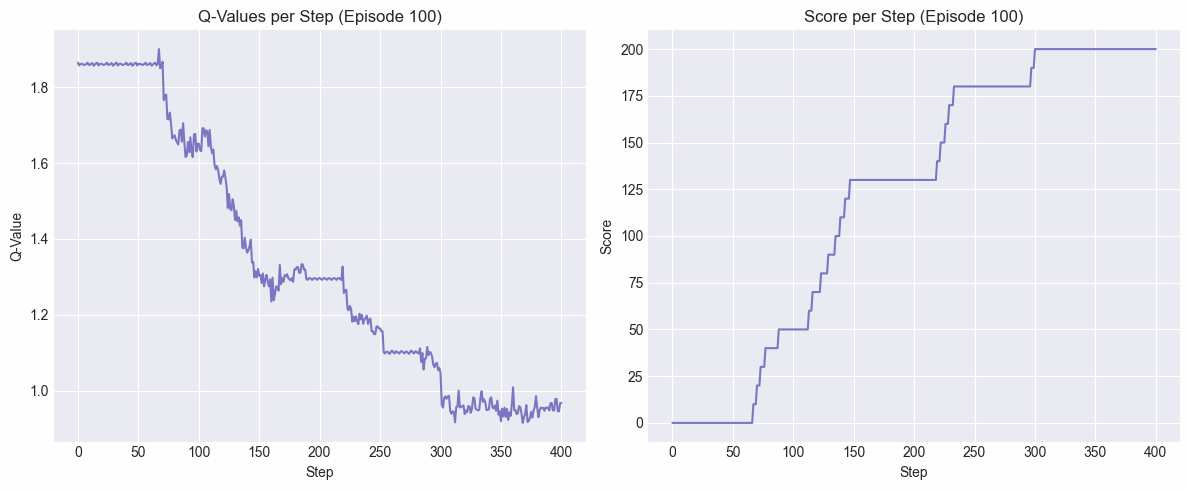

In [338]:
# Виклик функції тестування
test_dqn_ft_agent("dqn_ft_pacman.pth", num_episodes=100)

#### 7. Реалізувати глибинну Q-мережу (DQN) з повторенням досвіду (Experience Replay, ER). Назвемо цю мережу DQN-ER.

In [351]:
def train_dqn_er_agent(env_name="ALE/MsPacman-v5", E=100, M=2000, gamma=0.99, epsilon_decay=0.995,
                       lr=0.0001, optimizer_type="Adam", buffer_size=10000, batch_size=32):

    # Створення середовища
    env = gym.make(env_name)
    state_shape = (1, 84, 84)  # Грейскейл зображення 84x84
    num_actions = env.action_space.n

    # Ініціалізація політики
    policy_net = DQN(state_shape, num_actions).to("cuda")
    optimizer = optim.Adam(policy_net.parameters(), lr=lr) if optimizer_type == "Adam" else optim.RMSprop(policy_net.parameters(), lr=lr)

    # Ініціалізація Experience Replay
    replay_buffer = deque(maxlen=buffer_size)

    epsilon = 1.0
    rewards_per_epoch = []
    q_values_per_epoch = []
    max_losses_per_epoch = []

    for epoch in range(E):
        total_reward = 0
        losses = []
        q_values = []

        for episode in range(M // E):  # Ділимо на кількість епізодів в кожній епосі
            state, _ = env.reset()
            state = preprocess_frame(state)
            state = torch.FloatTensor(state).unsqueeze(0).to("cuda")
            done = False

            while not done:
                # Вибір дії
                if random.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    with torch.no_grad():
                        q_values_state = policy_net(state)
                        action = torch.argmax(q_values_state).item()

                # Виконання дії
                next_state, reward, terminated, truncated, _ = env.step(action)
                reward /= 100
                next_state = preprocess_frame(next_state)
                next_state = torch.FloatTensor(next_state).unsqueeze(0).to("cuda")

                # Збереження досвіду в буфер
                replay_buffer.append((state, action, reward, next_state, terminated or truncated))
                state = next_state
                total_reward += reward
                done = terminated or truncated

                # Повторюване навчання, якщо буфер достатньо заповнений
                if len(replay_buffer) >= batch_size:
                    minibatch = random.sample(replay_buffer, batch_size)
                    states, actions, rewards, next_states, dones = zip(*minibatch)

                    states = torch.cat(states).to("cuda")
                    actions = torch.tensor(actions, dtype=torch.long).to("cuda")
                    rewards = torch.tensor(rewards, dtype=torch.float32).to("cuda")
                    next_states = torch.cat(next_states).to("cuda")
                    dones = torch.tensor(dones, dtype=torch.float32).to("cuda")

                    # Обчислення поточних і цільових Q-значень
                    current_q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze()
                    with torch.no_grad():
                        next_q_values = policy_net(next_states).max(1)[0]
                    target_q_values = rewards + gamma * next_q_values * (1 - dones)

                    # Оновлення мережі
                    loss = F.mse_loss(current_q_values, target_q_values)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    losses.append(loss.item())

        # Зменшення epsilon
        epsilon = max(epsilon * epsilon_decay, 0.1)

        # Запис статистики
        max_loss = max(losses) if losses else 0
        rewards_per_epoch.append(total_reward / (M // E))
        max_losses_per_epoch.append(max_loss)

        # Валідаційний епізод
        state, _ = env.reset()
        state = preprocess_frame(state)
        state = torch.FloatTensor(state).unsqueeze(0).to("cuda")
        done = False
        total_q_validation = 0
        steps = 0

        while not done:
            with torch.no_grad():
                q_values_validation = policy_net(state)
                total_q_validation += q_values_validation.max(1)[0].item()
                action = torch.argmax(q_values_validation).item()

            next_state, _, terminated, truncated, _ = env.step(action)
            next_state = preprocess_frame(next_state)
            next_state = torch.FloatTensor(next_state).unsqueeze(0).to("cuda")
            state = next_state
            done = terminated or truncated
            steps += 1

        avg_q_validation = total_q_validation / steps if steps > 0 else 0
        q_values_per_epoch.append(avg_q_validation)

        print(f"Epoch {epoch+1}/{E}: Reward={rewards_per_epoch[-1]:.2f}, Avg Q-Validation={avg_q_validation:.2f}, Max Loss={max_loss:.4f}")

    # Збереження моделі
    model_save_path = "dqn_er_pacman.pth"
    torch.save(policy_net.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

    # Графіки
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(rewards_per_epoch)
    plt.title("Average Reward per Epoch")

    plt.subplot(1, 3, 2)
    plt.plot(q_values_per_epoch)
    plt.title("Average Q-Value per Epoch (Validation)")

    plt.subplot(1, 3, 3)
    plt.plot(max_losses_per_epoch)
    plt.title("Max Loss per Epoch")

    plt.show()

    return policy_net

Epoch 1/100: Reward=2.22, Avg Q-Validation=1.35, Max Loss=0.1957
Epoch 2/100: Reward=3.27, Avg Q-Validation=1.44, Max Loss=1.7926
Epoch 3/100: Reward=4.32, Avg Q-Validation=1.29, Max Loss=2.1661
Epoch 4/100: Reward=2.66, Avg Q-Validation=1.22, Max Loss=1.6429
Epoch 5/100: Reward=2.88, Avg Q-Validation=0.99, Max Loss=1.1119
Epoch 6/100: Reward=4.13, Avg Q-Validation=1.27, Max Loss=0.3267
Epoch 7/100: Reward=3.10, Avg Q-Validation=1.47, Max Loss=0.6130
Epoch 8/100: Reward=3.16, Avg Q-Validation=1.87, Max Loss=0.4375
Epoch 9/100: Reward=4.00, Avg Q-Validation=2.05, Max Loss=0.2565
Epoch 10/100: Reward=6.50, Avg Q-Validation=1.52, Max Loss=0.8089
Epoch 11/100: Reward=5.35, Avg Q-Validation=2.17, Max Loss=1.7537
Epoch 12/100: Reward=4.41, Avg Q-Validation=1.68, Max Loss=0.6336
Epoch 13/100: Reward=3.50, Avg Q-Validation=1.44, Max Loss=0.5559
Epoch 14/100: Reward=6.48, Avg Q-Validation=2.18, Max Loss=0.6296
Epoch 15/100: Reward=3.91, Avg Q-Validation=1.69, Max Loss=0.9349
Epoch 16/100: Rewar

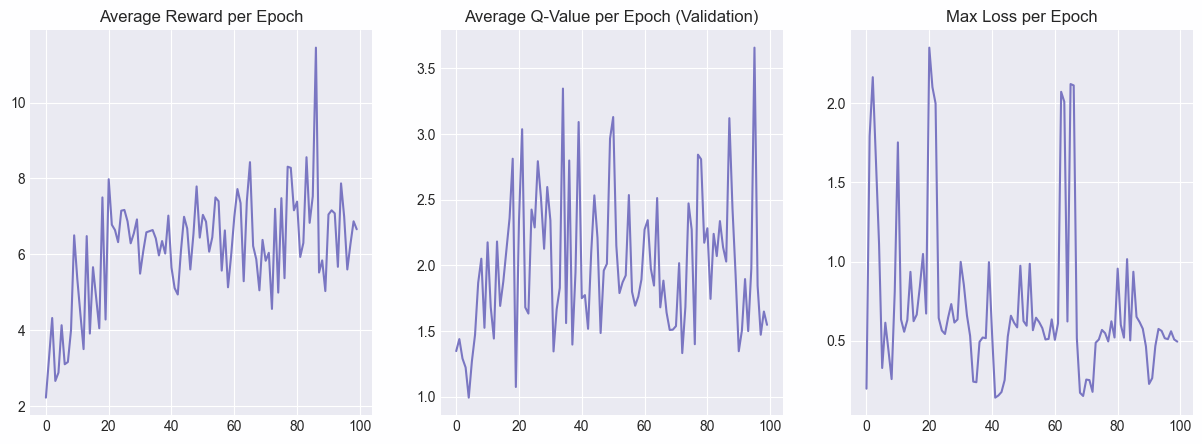

In [352]:
trained_policy_net_ft  = train_dqn_er_agent(E=100, M=1000, gamma=0.99, epsilon_decay=0.9, lr=0.00001, optimizer_type="Adam")

#### 8. Повторити завдання 3, 4 для мережі DQN-ER. Порівняйте отримані результати з відповідними результатами 3, 4 та зробіть висновки. Для навчання використати наступні гіперпараметри, пов'язані з повторенням досвіду:
- #### довжина черги записаних кроків: $10E \cdot M$.
- #### крок, після якого запускається повторюване навчання: $\frac{E \cdot M}{10}$.
- #### обсяг міні-вибірки (minibatch size): $8$, або $16$, або $32$.

In [353]:
def test_dqn_er_agent(model_path, env_name="ALE/MsPacman-v5", num_episodes=100):
    # Завантаження середовища
    env = gym.make(env_name)
    state_shape = (1, 84, 84)
    num_actions = env.action_space.n

    # Ініціалізація політики
    policy_net = DQN(state_shape, num_actions).to("cuda")
    policy_net.load_state_dict(torch.load(model_path, weights_only=True))
    policy_net.eval()

    episode_rewards = []
    episode_lengths = []

    q_values_data = {}
    scores_data = {}

    random_episode = random.randint(1, num_episodes)

    for episode in range(1, num_episodes + 1):
        state, _ = env.reset()
        state = preprocess_frame(state)
        state = torch.FloatTensor(state).unsqueeze(0).to("cuda")
        done = False

        total_reward = 0
        steps = 0

        q_values = []
        scores = []

        while not done:
            with torch.no_grad():
                q_values_state = policy_net(state)
                action = torch.argmax(q_values_state).item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward

            q_values.append(q_values_state.max(1)[0].item())
            scores.append(total_reward)

            next_state = preprocess_frame(next_state)
            state = torch.FloatTensor(next_state).unsqueeze(0).to("cuda")

            done = terminated or truncated
            steps += 1

        episode_rewards.append(total_reward)
        episode_lengths.append(steps)

        # Збереження даних для епізодів 1, random_episode, 100
        if episode in {1, random_episode, num_episodes}:
            q_values_data[episode] = q_values
            scores_data[episode] = scores

    # Графіки винагород і тривалості епізодів
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(episode_rewards)
    plt.title("Rewards per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Reward")

    plt.subplot(1, 2, 2)
    plt.plot(episode_lengths)
    plt.title("Episode Lengths")
    plt.xlabel("Episode")
    plt.ylabel("Steps")

    plt.tight_layout()
    plt.show()

    # Графіки Q-Values і Score для епізодів 1, random_episode, 100
    for episode in [1, random_episode, num_episodes]:
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(q_values_data[episode])
        plt.title(f"Q-Values per Step (Episode {episode})")
        plt.xlabel("Step")
        plt.ylabel("Q-Value")

        plt.subplot(1, 2, 2)
        plt.plot(scores_data[episode])
        plt.title(f"Score per Step (Episode {episode})")
        plt.xlabel("Step")
        plt.ylabel("Score")

        plt.tight_layout()
        plt.show()

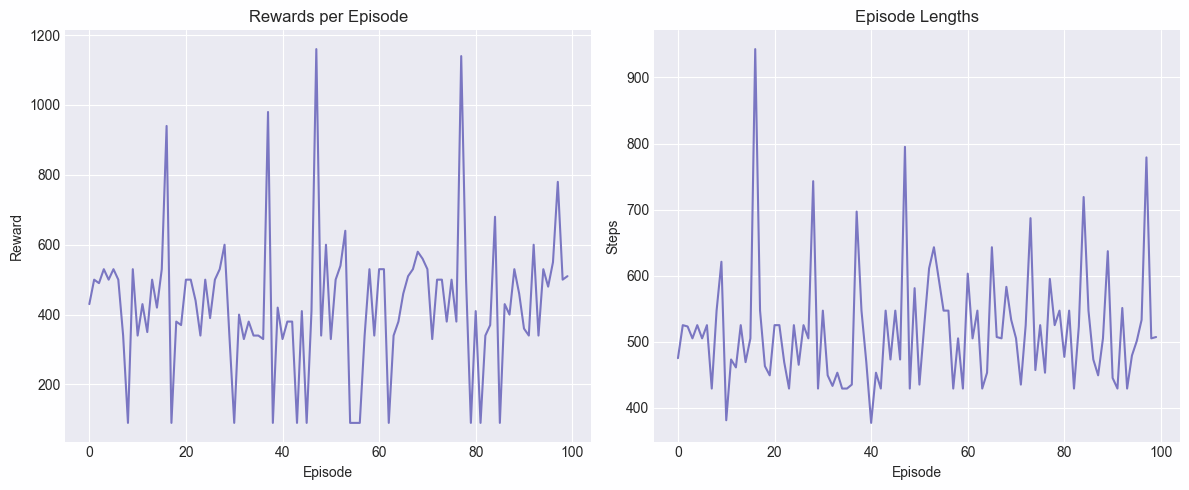

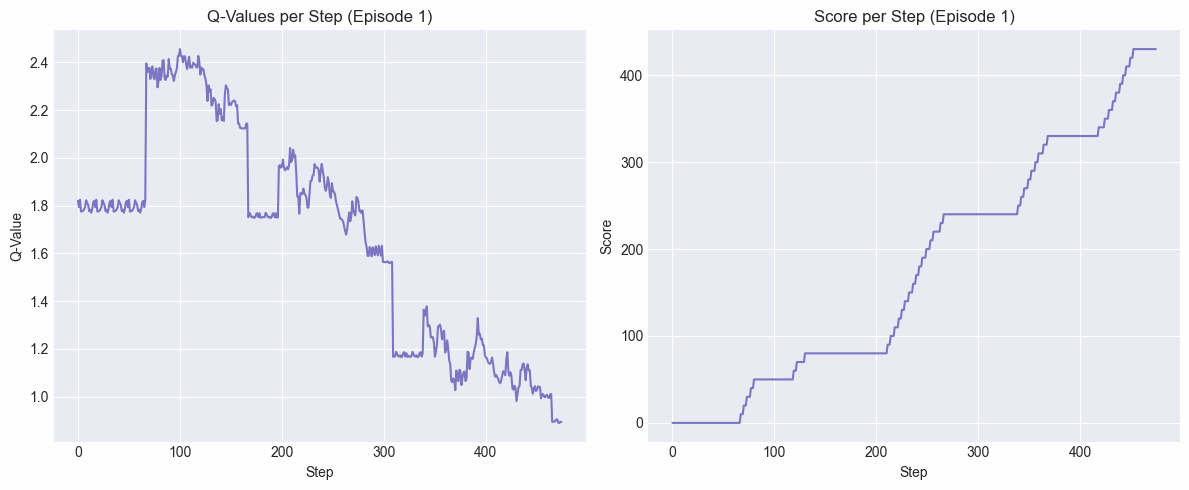

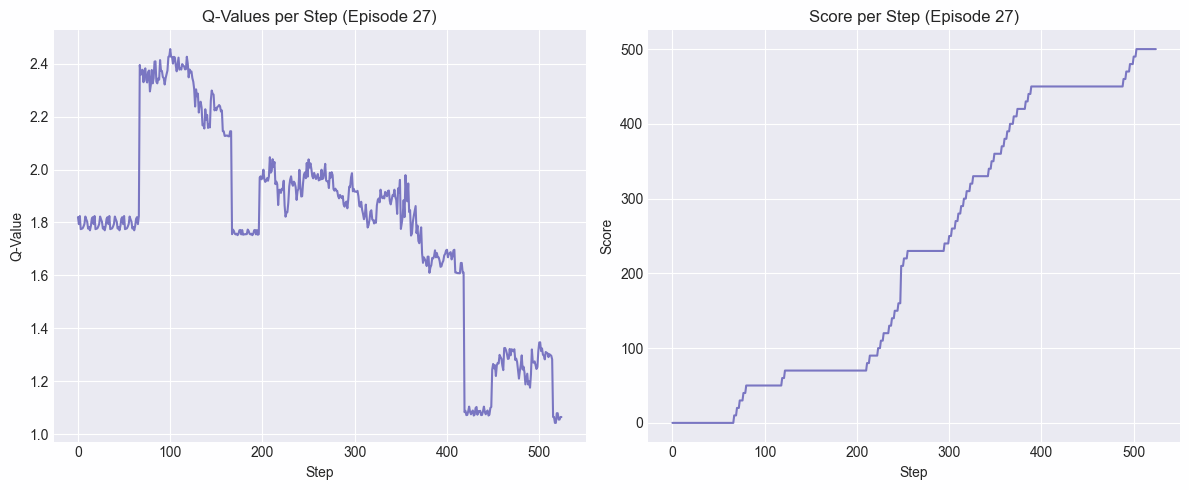

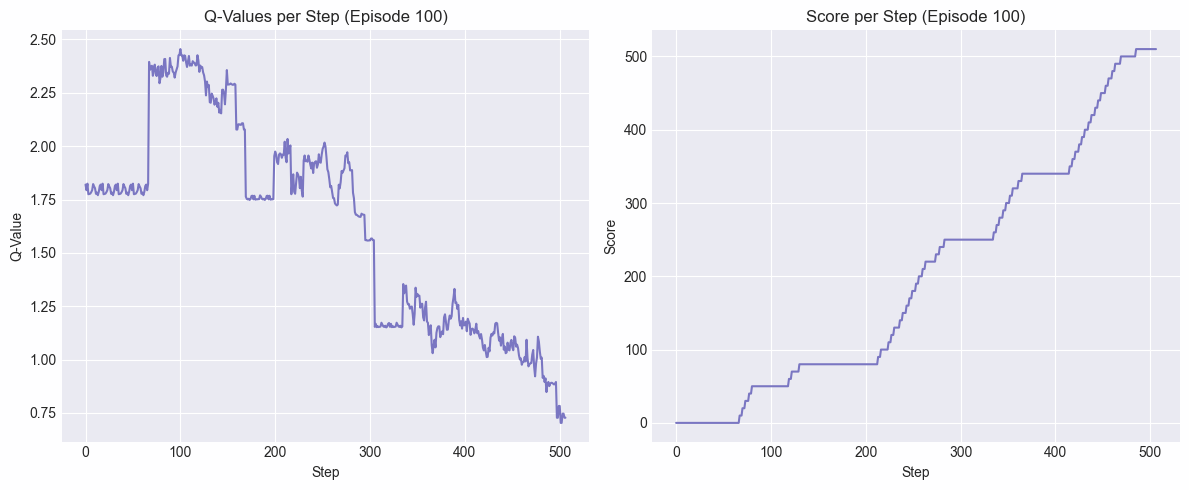

In [354]:
test_dqn_er_agent("dqn_er_pacman.pth", num_episodes=100)

#### 9. Реалізувати глибинну Q-мережу (DQN) з фіксованою цільвою мережею та повторенням досвіду. Назвемо цю мережу DQN-FT-ER.

In [448]:
class FrameStack:
    def __init__(self, K):
        self.K = K
        self.frames = deque(maxlen=K)

    def reset(self, initial_frame):
        self.frames.clear()
        for _ in range(self.K):
            self.frames.append(initial_frame)
        return self.get_stack()

    def step(self, next_frame):
        self.frames.append(next_frame)
        return self.get_stack()

    def get_stack(self):
        # Повертає стек у форматі (K, 84, 84)
        stack = torch.cat(list(self.frames), dim=0)
        return stack.unsqueeze(0)  # Додаємо batch dimension

In [432]:
def train_dqn_ft_er_agent(env_name="ALE/MsPacman-v5", E=100, M=2000, gamma=0.99, epsilon_decay=0.995,
                               lr=0.0001, optimizer_type="Adam", buffer_size=10000, batch_size=32, K=1, modification='dqn_ft_er_pacman'):
    # Створення середовища
    env = gym.make(env_name)
    state_shape = (K, 84, 84)  # Вхідний стек із K кадрів
    num_actions = env.action_space.n

    # Ініціалізація політики та цільової мережі
    policy_net = DQN(state_shape, num_actions).to("cuda")
    target_net = DQN(state_shape, num_actions).to("cuda")
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=lr) if optimizer_type == "Adam" else optim.RMSprop(policy_net.parameters(), lr=lr)

    # Ініціалізація Experience Replay
    replay_buffer = deque(maxlen=buffer_size)

    # Ініціалізація стека кадрів
    frame_stack = FrameStack(K)

    epsilon = 1.0
    rewards_per_epoch = []
    q_values_per_epoch = []
    max_losses_per_epoch = []

    for epoch in range(E):
        total_reward = 0
        losses = []
        q_values = []

        for episode in range(M // E):
            initial_frame, _ = env.reset()
            state = frame_stack.reset(preprocess_frame(initial_frame).to("cuda"))
            done = False

            while not done:
                # Вибір дії
                if random.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    with torch.no_grad():
                        q_values_state = policy_net(state)
                        action = torch.argmax(q_values_state).item()

                # Виконання дії
                next_frame, reward, terminated, truncated, _ = env.step(action)
                reward /= 100
                next_state = frame_stack.step(preprocess_frame(next_frame).to("cuda"))

                # Збереження досвіду в буфер
                replay_buffer.append((state, action, reward, next_state, terminated or truncated))
                state = next_state
                total_reward += reward
                done = terminated or truncated

                # Повторюване навчання, якщо буфер достатньо заповнений
                if len(replay_buffer) >= batch_size:
                    minibatch = random.sample(replay_buffer, batch_size)
                    states, actions, rewards, next_states, dones = zip(*minibatch)

                    states = torch.cat(states).to("cuda")
                    actions = torch.tensor(actions, dtype=torch.long).to("cuda")
                    rewards = torch.tensor(rewards, dtype=torch.float32).to("cuda")
                    next_states = torch.cat(next_states).to("cuda")
                    dones = torch.tensor(dones, dtype=torch.float32).to("cuda")

                    # Обчислення поточних і цільових Q-значень з використанням target_net
                    current_q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze()
                    with torch.no_grad():
                        next_q_values = target_net(next_states).max(1)[0]
                    target_q_values = rewards + gamma * next_q_values * (1 - dones)

                    # Оновлення мережі
                    loss = F.mse_loss(current_q_values, target_q_values)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    losses.append(loss.item())

        # Оновлення параметрів target_net кожну епоху
        target_net.load_state_dict(policy_net.state_dict())

        # Зменшення epsilon
        epsilon = max(epsilon * epsilon_decay, 0.1)

        # Запис статистики
        max_loss = max(losses) if losses else 0
        rewards_per_epoch.append(total_reward / (M // E))
        max_losses_per_epoch.append(max_loss)

        # Валідаційний епізод
        initial_frame, _ = env.reset()
        state = frame_stack.reset(preprocess_frame(initial_frame).to("cuda"))
        done = False
        total_q_validation = 0
        steps = 0

        while not done:
            with torch.no_grad():
                q_values_validation = policy_net(state)
                total_q_validation += q_values_validation.max(1)[0].item()
                action = torch.argmax(q_values_validation).item()

            next_frame, _, terminated, truncated, _ = env.step(action)
            state = frame_stack.step(preprocess_frame(next_frame).to("cuda"))
            done = terminated or truncated
            steps += 1

        avg_q_validation = total_q_validation / steps if steps > 0 else 0
        q_values_per_epoch.append(avg_q_validation)

        print(f"Epoch {epoch+1}/{E}: Reward={rewards_per_epoch[-1]:.2f}, Avg Q-Validation={avg_q_validation:.2f}, Max Loss={max_loss:.4f}")

    # Збереження моделі
    model_save_path = f'{modification}.pth'
    torch.save(policy_net.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

    # Графіки
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(rewards_per_epoch)
    plt.title("Average Reward per Epoch")

    plt.subplot(1, 3, 2)
    plt.plot(q_values_per_epoch)
    plt.title("Average Q-Value per Epoch (Validation)")

    plt.subplot(1, 3, 3)
    plt.plot(max_losses_per_epoch)
    plt.title("Max Loss per Epoch")

    plt.show()

Epoch 1/100: Reward=2.38, Avg Q-Validation=0.04, Max Loss=0.0020
Epoch 2/100: Reward=2.49, Avg Q-Validation=0.06, Max Loss=0.0020
Epoch 3/100: Reward=4.18, Avg Q-Validation=0.06, Max Loss=0.1251
Epoch 4/100: Reward=2.63, Avg Q-Validation=0.07, Max Loss=0.1236
Epoch 5/100: Reward=3.57, Avg Q-Validation=0.09, Max Loss=0.5013
Epoch 6/100: Reward=4.08, Avg Q-Validation=0.11, Max Loss=0.4992
Epoch 7/100: Reward=4.87, Avg Q-Validation=0.12, Max Loss=0.5163
Epoch 8/100: Reward=4.38, Avg Q-Validation=0.15, Max Loss=0.5045
Epoch 9/100: Reward=3.88, Avg Q-Validation=0.12, Max Loss=0.4883
Epoch 10/100: Reward=5.94, Avg Q-Validation=0.17, Max Loss=0.1286
Epoch 11/100: Reward=4.62, Avg Q-Validation=0.18, Max Loss=0.2440
Epoch 12/100: Reward=7.34, Avg Q-Validation=0.20, Max Loss=0.2390
Epoch 13/100: Reward=5.00, Avg Q-Validation=0.23, Max Loss=0.2385
Epoch 14/100: Reward=5.64, Avg Q-Validation=0.26, Max Loss=0.5485
Epoch 15/100: Reward=5.89, Avg Q-Validation=0.22, Max Loss=0.6287
Epoch 16/100: Rewar

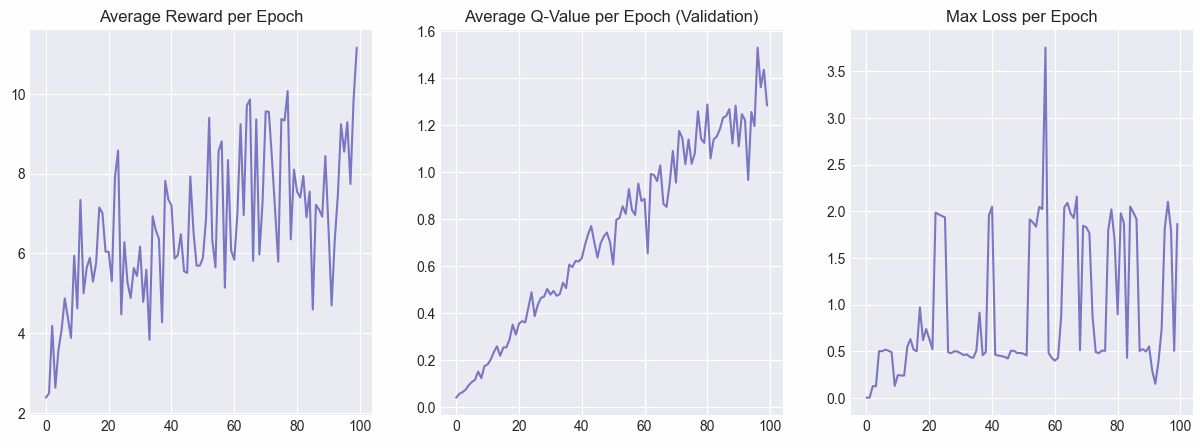

In [357]:
trained_policy_net_ft_er  = train_dqn_ft_er_agent(E=100, M=1000, gamma=0.99, epsilon_decay=0.9, lr=0.00001, optimizer_type="Adam")

#### 10. Повторити завдання 3, 4 для мережі DQN-FT-ER. Порівняйте отримані результати з відповідними результатами 3, 4 та зробіть висновки. Для навчання моделі скористатися гіперпараметрами, вказаними у завданнях $3$, $6$, $7$.

In [433]:
def test_dqn_ft_er_agent(model_path, env_name="ALE/MsPacman-v5", num_episodes=100, K=1):
    """
    Тестування агента DQN-FT-ER з підтримкою K кадрів.
    Вивід: графіки винагород, тривалості епізодів та Q-Values і Scores для обраних епізодів.
    """
    # Завантаження середовища
    env = gym.make(env_name)
    state_shape = (K, 84, 84)  # Вхідний стек із K кадрів
    num_actions = env.action_space.n

    # Завантаження політики
    policy_net = DQN(state_shape, num_actions).to("cuda")
    policy_net.load_state_dict(torch.load(model_path, weights_only=True))
    policy_net.eval()

    # Ініціалізація стека кадрів
    frame_stack = FrameStack(K)

    episode_rewards = []
    episode_lengths = []

    q_values_data = {}
    scores_data = {}

    # Випадковий епізод
    random_episode = random.randint(1, num_episodes)

    for episode in range(1, num_episodes + 1):
        initial_frame, _ = env.reset()
        state = frame_stack.reset(preprocess_frame(initial_frame).to("cuda"))
        done = False

        total_reward = 0
        steps = 0

        q_values = []
        scores = []

        while not done:
            with torch.no_grad():
                # Вибір дії
                q_values_state = policy_net(state)
                action = torch.argmax(q_values_state).item()

            # Виконання дії
            next_frame, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward

            # Збереження Q-Values і Score
            q_values.append(q_values_state.max(1)[0].item())
            scores.append(total_reward)

            # Перехід до наступного стану
            state = frame_stack.step(preprocess_frame(next_frame).to("cuda"))

            done = terminated or truncated
            steps += 1

        # Збереження результатів епізоду
        episode_rewards.append(total_reward)
        episode_lengths.append(steps)

        # Збереження даних для епізодів 1, random_episode, 100
        if episode in {1, random_episode, num_episodes}:
            q_values_data[episode] = q_values
            scores_data[episode] = scores

    # Графіки винагород і тривалості епізодів
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(episode_rewards)
    plt.title("Rewards per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Reward")

    plt.subplot(1, 2, 2)
    plt.plot(episode_lengths)
    plt.title("Episode Lengths")
    plt.xlabel("Episode")
    plt.ylabel("Steps")

    plt.tight_layout()
    plt.show()

    # Графіки Q-Values і Score для епізодів 1, random_episode, 100
    for episode in [1, random_episode, num_episodes]:
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(q_values_data[episode])
        plt.title(f"Q-Values per Step (Episode {episode})")
        plt.xlabel("Step")
        plt.ylabel("Q-Value")

        plt.subplot(1, 2, 2)
        plt.plot(scores_data[episode])
        plt.title(f"Score per Step (Episode {episode})")
        plt.xlabel("Step")
        plt.ylabel("Score")

        plt.tight_layout()
        plt.show()

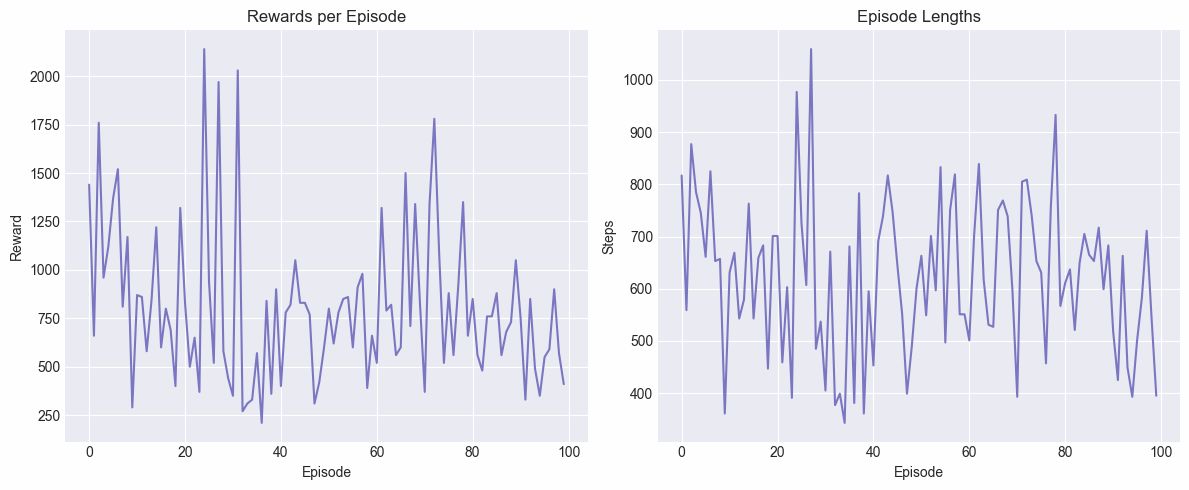

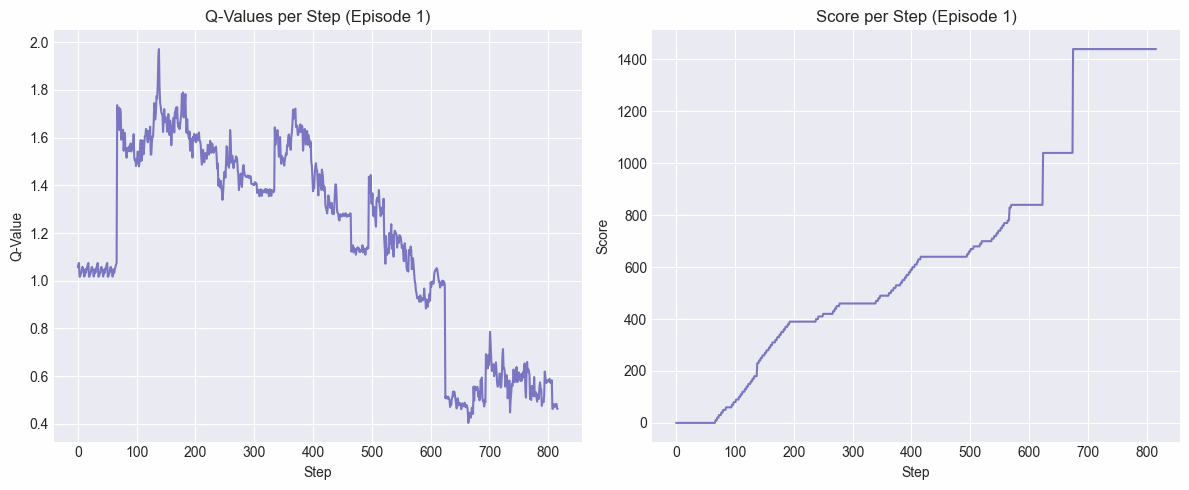

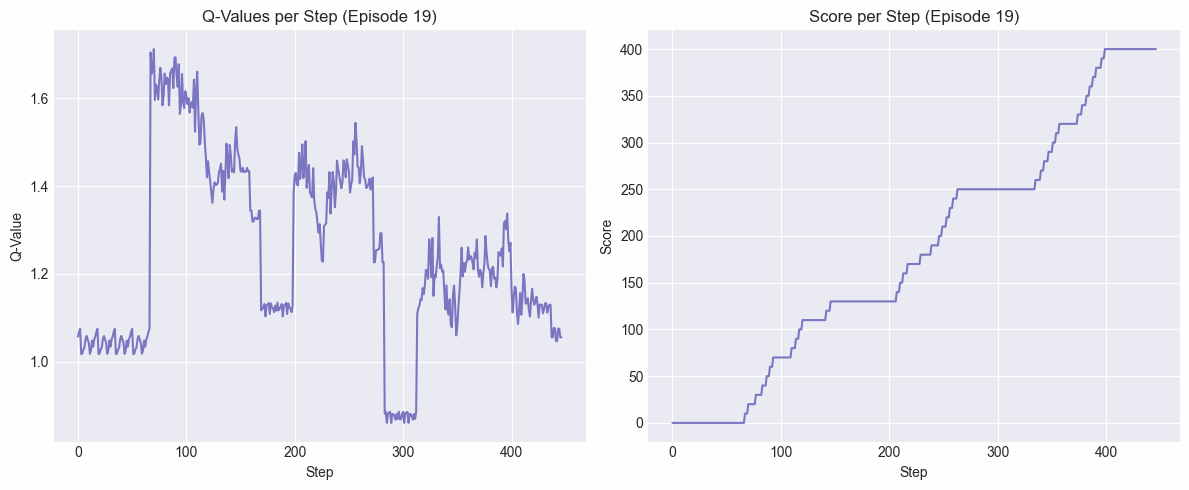

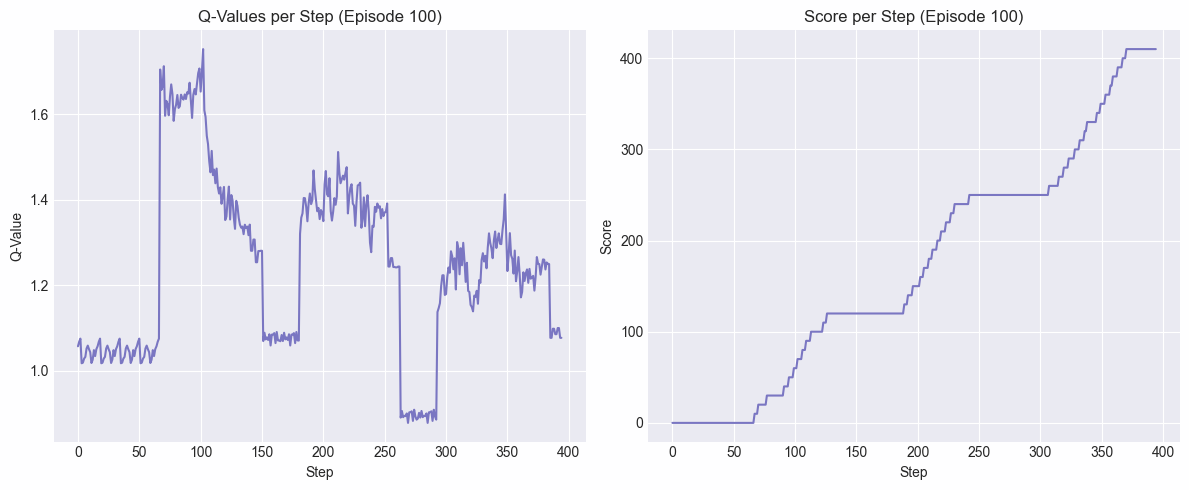

In [359]:
test_dqn_ft_er_agent("dqn_ft_er_pacman.pth", num_episodes=100)

#### 11. Для моделі DQN-FT-ER повторити завдання 3, 4, дослідивши вплив зміни гіперпараметрів, які не стосуються структури нейронної мережі, на навчання і якість прогнозування. Зокрема перевірити вплив зміни наступного гіперпараметру:
> #### a. $K \in \{1, 2, 4\}$;
> #### b. $\lambda$;
> #### c. $\Delta\epsilon$;
> #### d. $C$;
> #### e. $\gamma$.

$K \in \{1, 2, 4\}$

Що таке K?

K визначає кількість кадрів (або станів), які використовуються для формування одного вхідного тензора.

В контексті Atari-оточень K-кадри дозволяють агенту враховувати динаміку, тобто зміну станів у часі.

K-кадри передаються в нейронну мережу як кількість каналів у вхідному тензорі.

Наприклад:

Якщо K=4, то на вхід мережі подається тензор розміром [batch_size, 4, 84, 84] (де 4 — це кількість каналів).

Epoch 1/100: Reward=2.94, Avg Q-Validation=0.08, Max Loss=0.1250
Epoch 2/100: Reward=2.13, Avg Q-Validation=0.09, Max Loss=0.0711
Epoch 3/100: Reward=2.76, Avg Q-Validation=0.11, Max Loss=0.0481
Epoch 4/100: Reward=3.82, Avg Q-Validation=0.12, Max Loss=0.4379
Epoch 5/100: Reward=3.18, Avg Q-Validation=0.11, Max Loss=0.1353
Epoch 6/100: Reward=3.06, Avg Q-Validation=0.13, Max Loss=0.1437
Epoch 7/100: Reward=3.26, Avg Q-Validation=0.14, Max Loss=0.1207
Epoch 8/100: Reward=3.32, Avg Q-Validation=0.18, Max Loss=0.0075
Epoch 9/100: Reward=4.94, Avg Q-Validation=0.17, Max Loss=0.4966
Epoch 10/100: Reward=4.11, Avg Q-Validation=0.20, Max Loss=0.4885
Epoch 11/100: Reward=3.80, Avg Q-Validation=0.26, Max Loss=0.3135
Epoch 12/100: Reward=7.02, Avg Q-Validation=0.22, Max Loss=0.5104
Epoch 13/100: Reward=5.58, Avg Q-Validation=0.27, Max Loss=0.4829
Epoch 14/100: Reward=5.26, Avg Q-Validation=0.31, Max Loss=0.4937
Epoch 15/100: Reward=5.36, Avg Q-Validation=0.41, Max Loss=0.4370
Epoch 16/100: Rewar

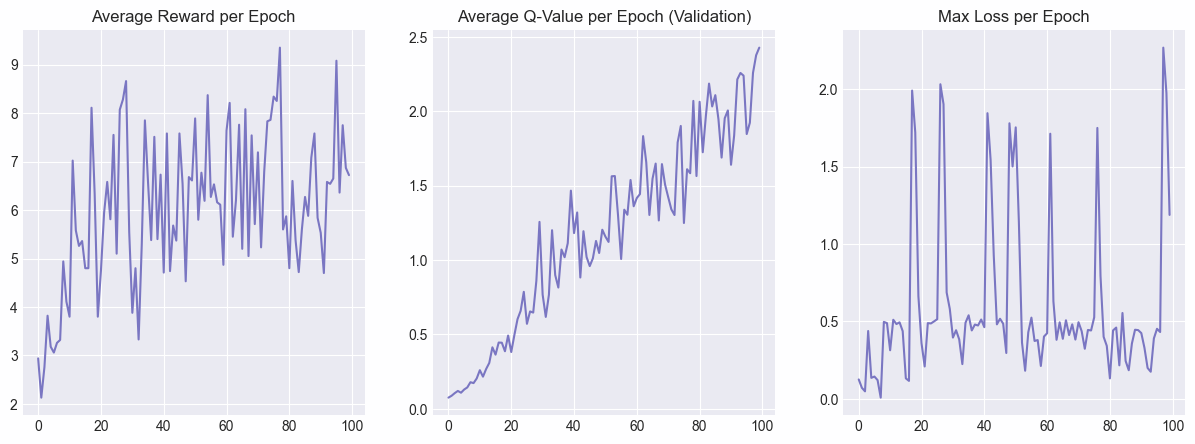

In [407]:
trained_policy_net_ft_er  = train_dqn_ft_er_agent(E=100, M=1000, gamma=0.99, epsilon_decay=0.9, lr=0.0001, 
                                                  optimizer_type="Adam", modification='dqn_ft_er_K2', K=2)

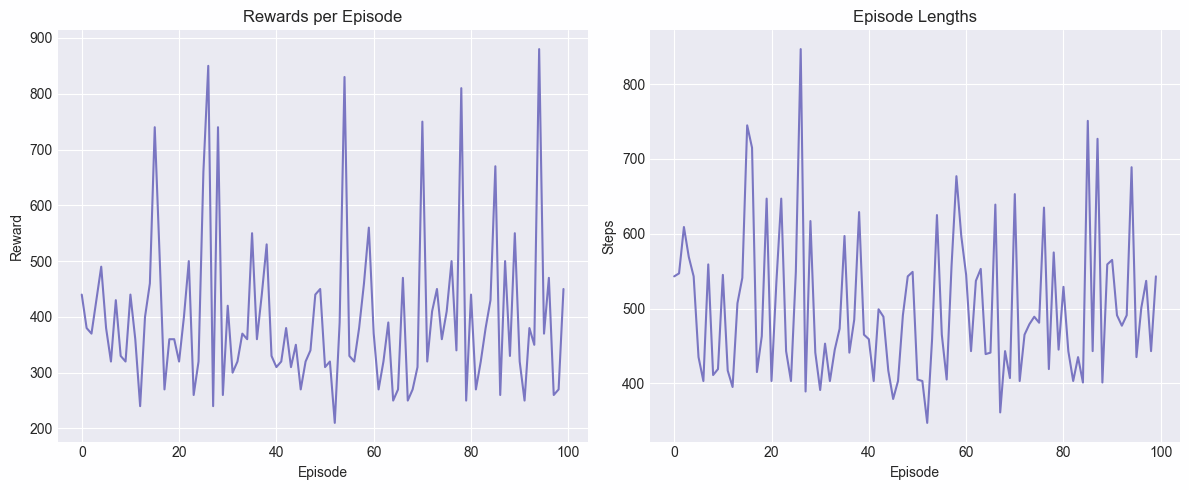

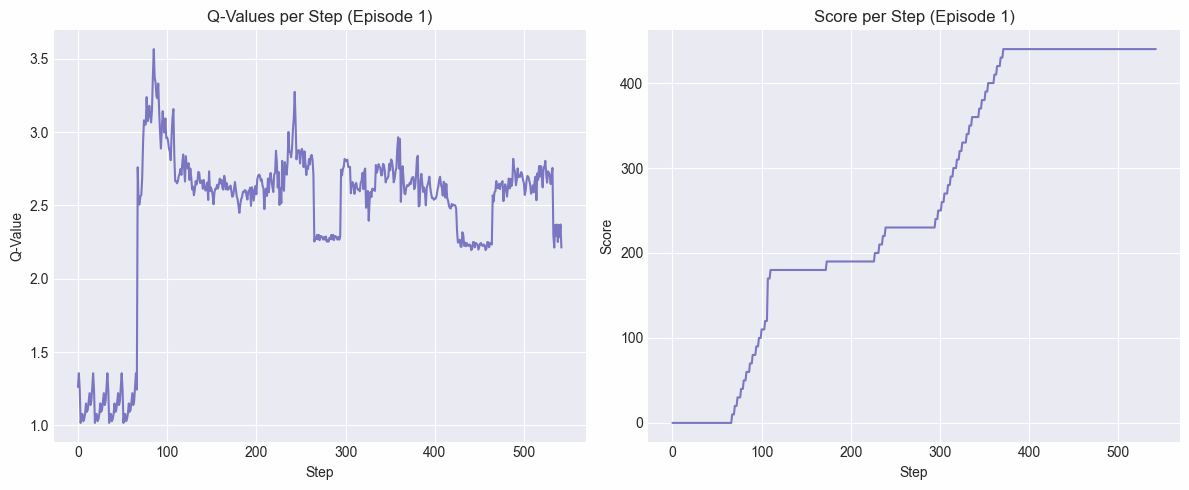

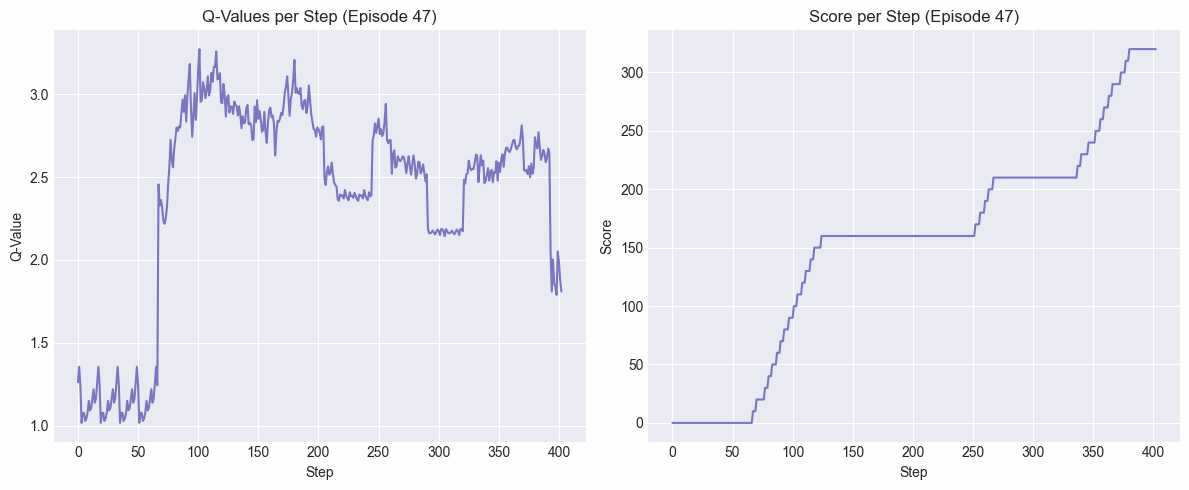

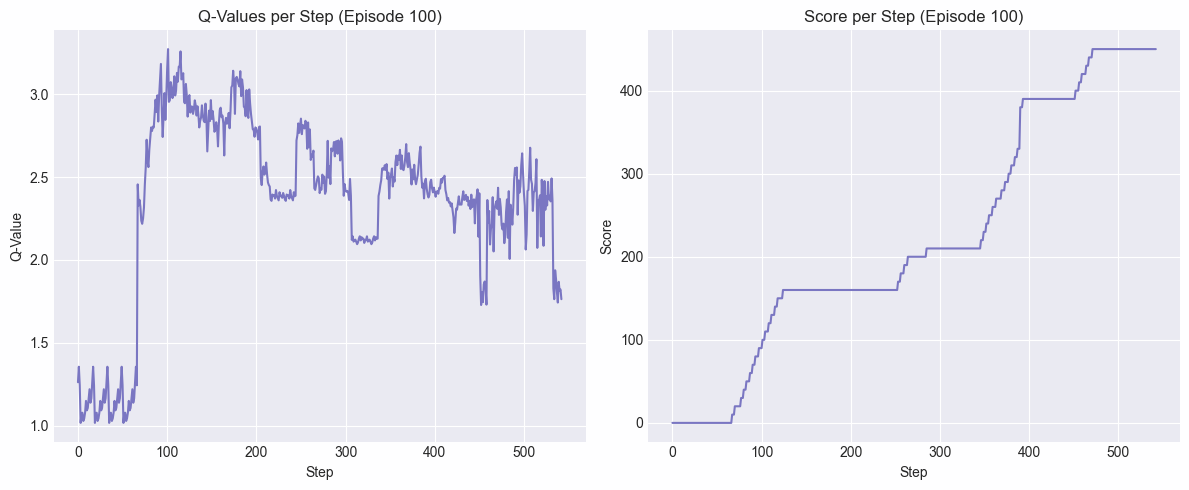

In [413]:
test_dqn_ft_er_agent("dqn_ft_er_K2.pth", num_episodes=100, K=2)

Epoch 1/100: Reward=2.47, Avg Q-Validation=0.06, Max Loss=0.0016
Epoch 2/100: Reward=2.75, Avg Q-Validation=0.09, Max Loss=0.0079
Epoch 3/100: Reward=2.45, Avg Q-Validation=0.11, Max Loss=0.0029
Epoch 4/100: Reward=3.51, Avg Q-Validation=0.12, Max Loss=0.0085
Epoch 5/100: Reward=3.44, Avg Q-Validation=0.14, Max Loss=0.1245
Epoch 6/100: Reward=4.01, Avg Q-Validation=0.17, Max Loss=0.4965
Epoch 7/100: Reward=3.33, Avg Q-Validation=0.18, Max Loss=0.4275
Epoch 8/100: Reward=4.25, Avg Q-Validation=0.20, Max Loss=0.4982
Epoch 9/100: Reward=3.81, Avg Q-Validation=0.23, Max Loss=0.1239
Epoch 10/100: Reward=3.45, Avg Q-Validation=0.25, Max Loss=0.0303
Epoch 11/100: Reward=4.44, Avg Q-Validation=0.34, Max Loss=0.1334
Epoch 12/100: Reward=5.10, Avg Q-Validation=0.31, Max Loss=0.1277
Epoch 13/100: Reward=4.19, Avg Q-Validation=0.35, Max Loss=0.1266
Epoch 14/100: Reward=3.85, Avg Q-Validation=0.39, Max Loss=0.0647
Epoch 15/100: Reward=4.97, Avg Q-Validation=0.39, Max Loss=0.1323
Epoch 16/100: Rewar

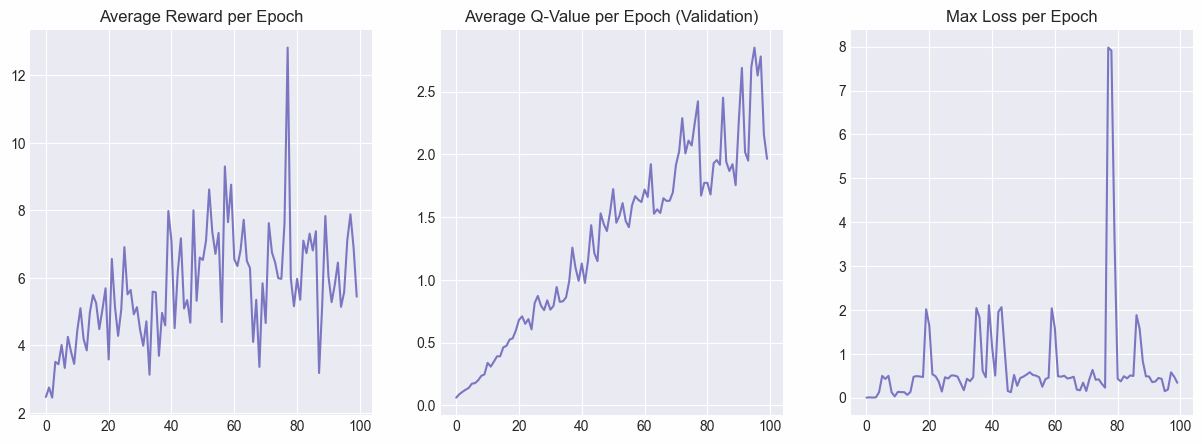

In [414]:
trained_policy_net_ft_er  = train_dqn_ft_er_agent(E=100, M=1000, gamma=0.99, epsilon_decay=0.9, lr=0.0001, 
                                                  optimizer_type="Adam", modification='dqn_ft_er_K4', K=4)

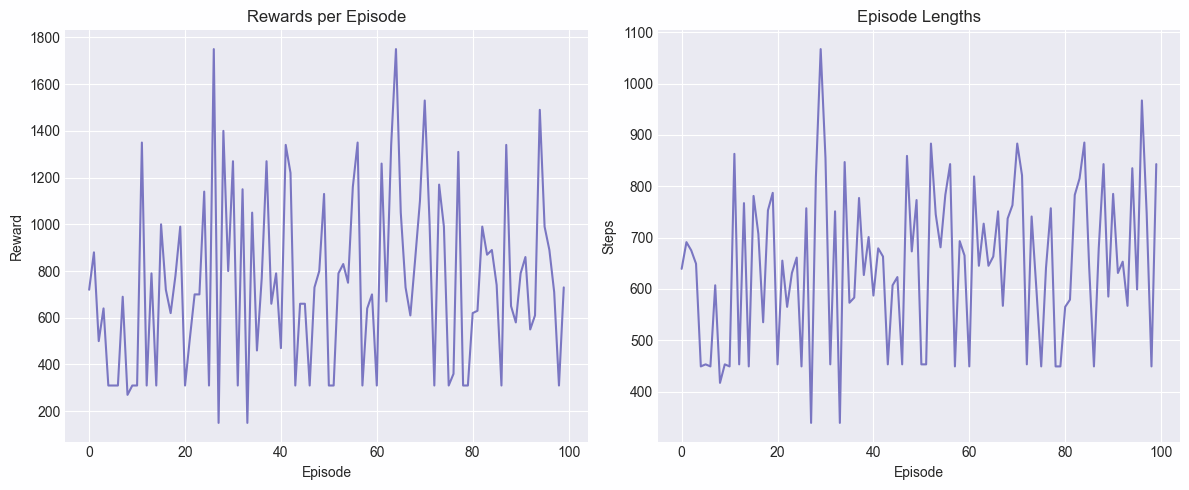

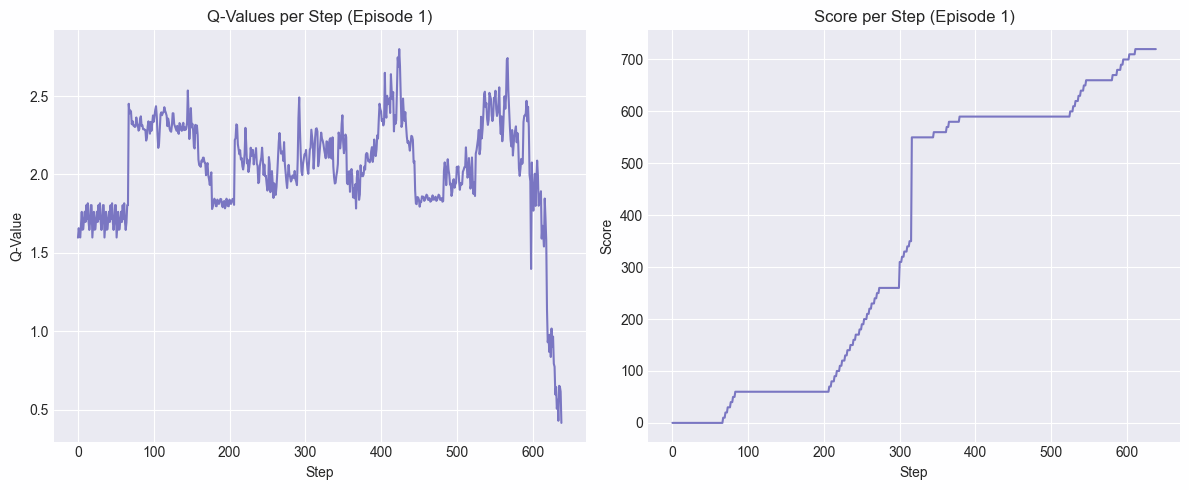

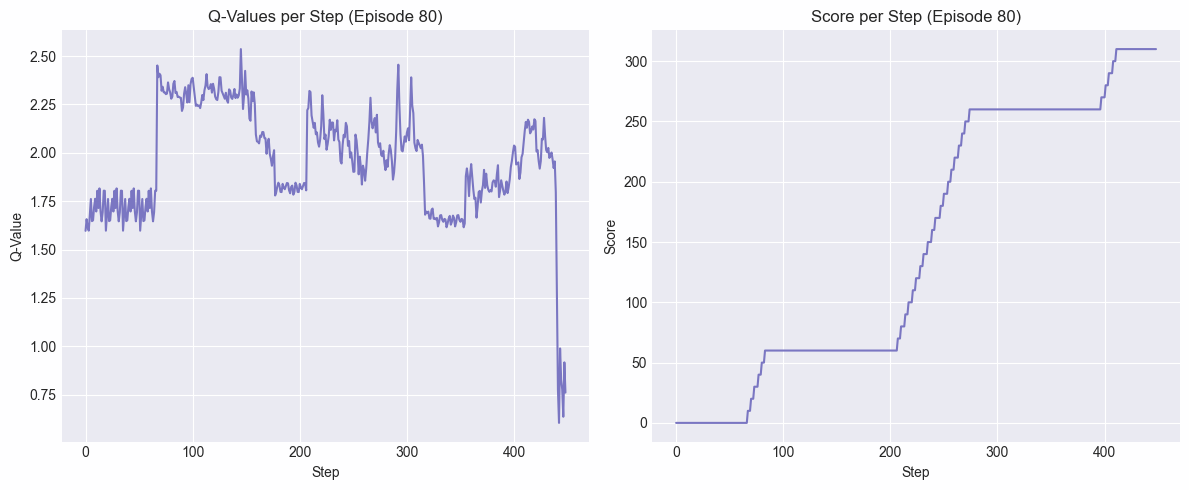

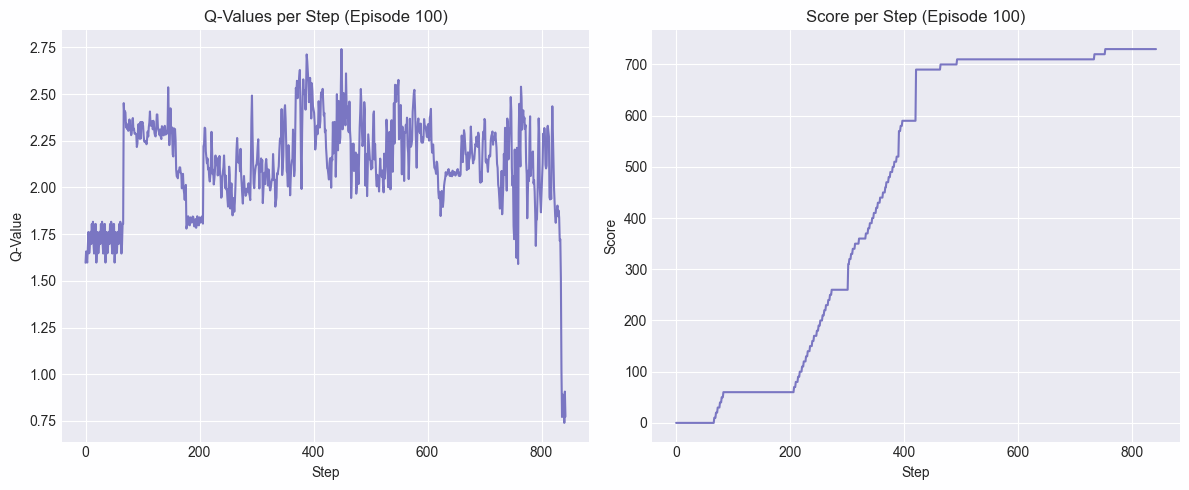

In [416]:
test_dqn_ft_er_agent("dqn_ft_er_K4.pth", num_episodes=100, K=4)

Epoch 1/100: Reward=2.23, Avg Q-Validation=0.04, Max Loss=0.0081
Epoch 2/100: Reward=2.51, Avg Q-Validation=0.05, Max Loss=0.0087
Epoch 3/100: Reward=2.71, Avg Q-Validation=0.06, Max Loss=0.0089
Epoch 4/100: Reward=2.67, Avg Q-Validation=0.08, Max Loss=0.0081
Epoch 5/100: Reward=3.23, Avg Q-Validation=0.08, Max Loss=0.1253
Epoch 6/100: Reward=3.68, Avg Q-Validation=0.10, Max Loss=0.1233
Epoch 7/100: Reward=3.26, Avg Q-Validation=0.10, Max Loss=0.1212
Epoch 8/100: Reward=3.56, Avg Q-Validation=0.12, Max Loss=0.0085
Epoch 9/100: Reward=4.53, Avg Q-Validation=0.11, Max Loss=0.1231
Epoch 10/100: Reward=5.31, Avg Q-Validation=0.13, Max Loss=0.5001
Epoch 11/100: Reward=4.24, Avg Q-Validation=0.13, Max Loss=0.4955
Epoch 12/100: Reward=5.07, Avg Q-Validation=0.16, Max Loss=0.5981
Epoch 13/100: Reward=4.85, Avg Q-Validation=0.18, Max Loss=0.1366
Epoch 14/100: Reward=7.25, Avg Q-Validation=0.18, Max Loss=0.6069
Epoch 15/100: Reward=7.53, Avg Q-Validation=0.18, Max Loss=0.6228
Epoch 16/100: Rewar

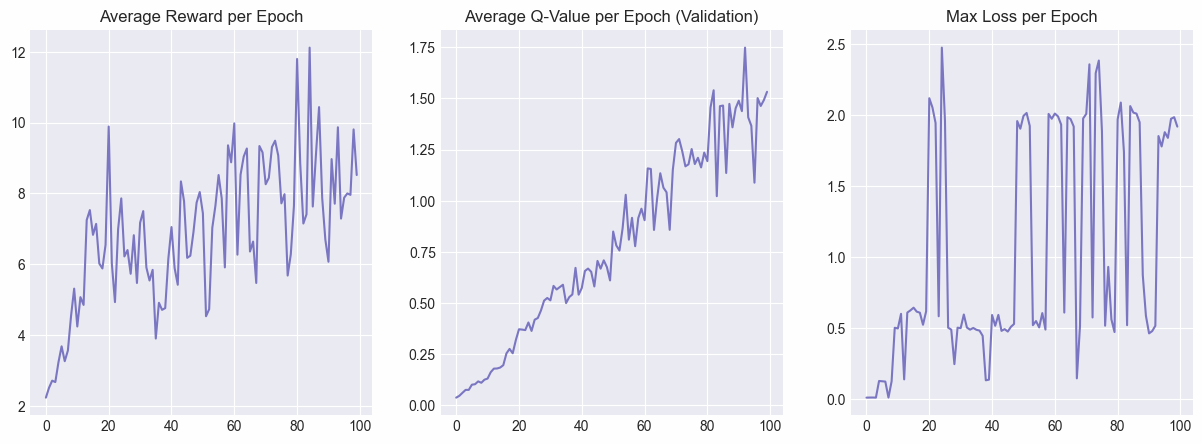

In [417]:
trained_policy_net_ft_er  = train_dqn_ft_er_agent(E=100, M=1000, gamma=0.99, epsilon_decay=0.9, lr=0.00001, 
                                                  optimizer_type="Adam", modification='dqn_ft_er_00001_K4', K=4)

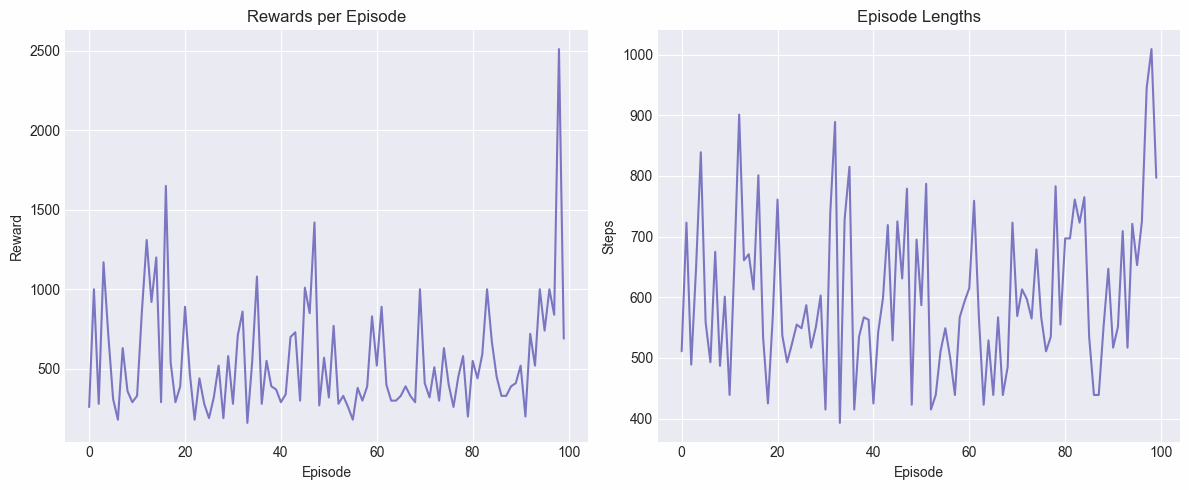

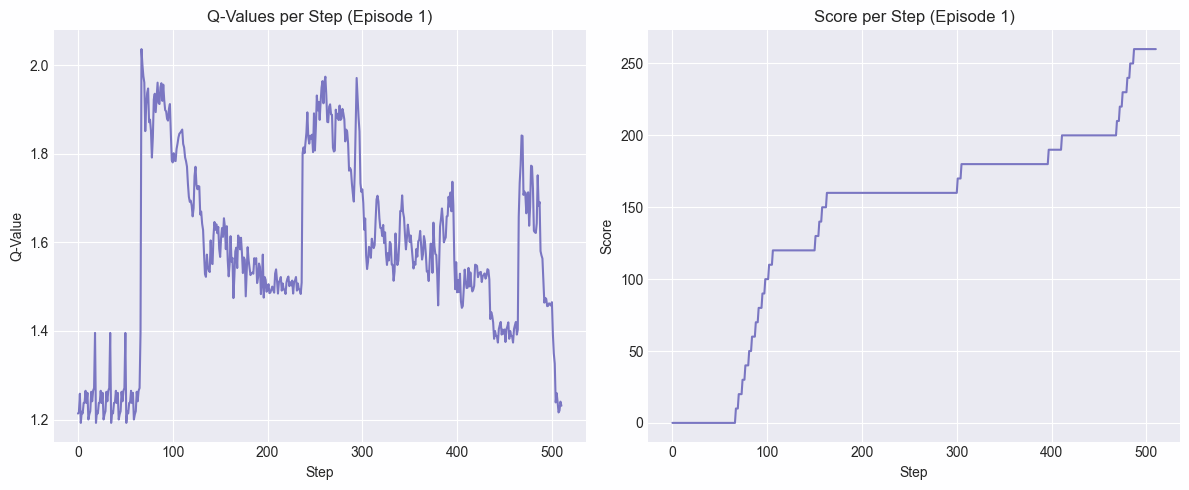

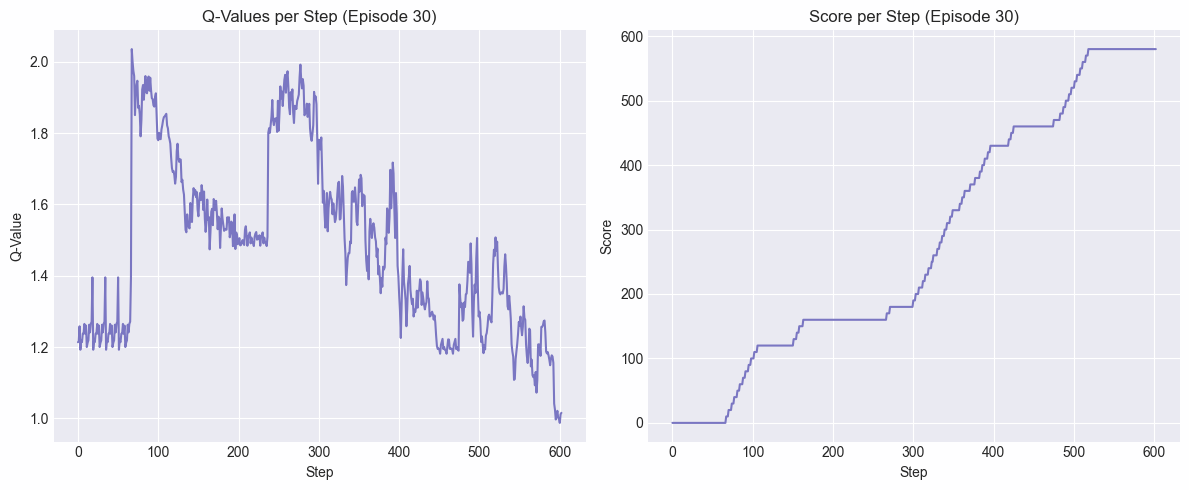

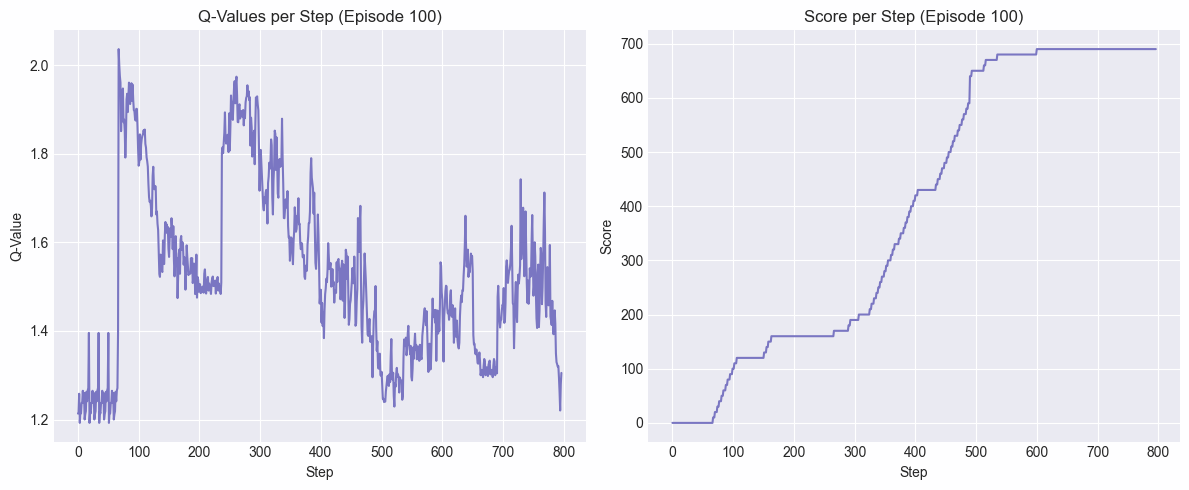

In [418]:
test_dqn_ft_er_agent("dqn_ft_er_00001_K4.pth", num_episodes=100, K=4)

## $\lambda$

Epoch 1/100: Reward=2.51, Avg Q-Validation=0.09, Max Loss=0.0044
Epoch 2/100: Reward=3.03, Avg Q-Validation=0.10, Max Loss=0.1370
Epoch 3/100: Reward=2.75, Avg Q-Validation=0.11, Max Loss=0.1342
Epoch 4/100: Reward=3.06, Avg Q-Validation=0.13, Max Loss=0.1202
Epoch 5/100: Reward=3.80, Avg Q-Validation=0.15, Max Loss=0.4936
Epoch 6/100: Reward=3.06, Avg Q-Validation=0.21, Max Loss=0.2980
Epoch 7/100: Reward=5.07, Avg Q-Validation=0.26, Max Loss=0.4987
Epoch 8/100: Reward=3.89, Avg Q-Validation=0.31, Max Loss=0.4638
Epoch 9/100: Reward=5.08, Avg Q-Validation=0.25, Max Loss=0.1361
Epoch 10/100: Reward=4.28, Avg Q-Validation=0.33, Max Loss=0.1454
Epoch 11/100: Reward=4.65, Avg Q-Validation=0.35, Max Loss=0.5027
Epoch 12/100: Reward=3.98, Avg Q-Validation=0.45, Max Loss=0.4982
Epoch 13/100: Reward=4.08, Avg Q-Validation=0.50, Max Loss=0.3871
Epoch 14/100: Reward=4.72, Avg Q-Validation=0.37, Max Loss=0.1439
Epoch 15/100: Reward=3.97, Avg Q-Validation=0.41, Max Loss=0.1308
Epoch 16/100: Rewar

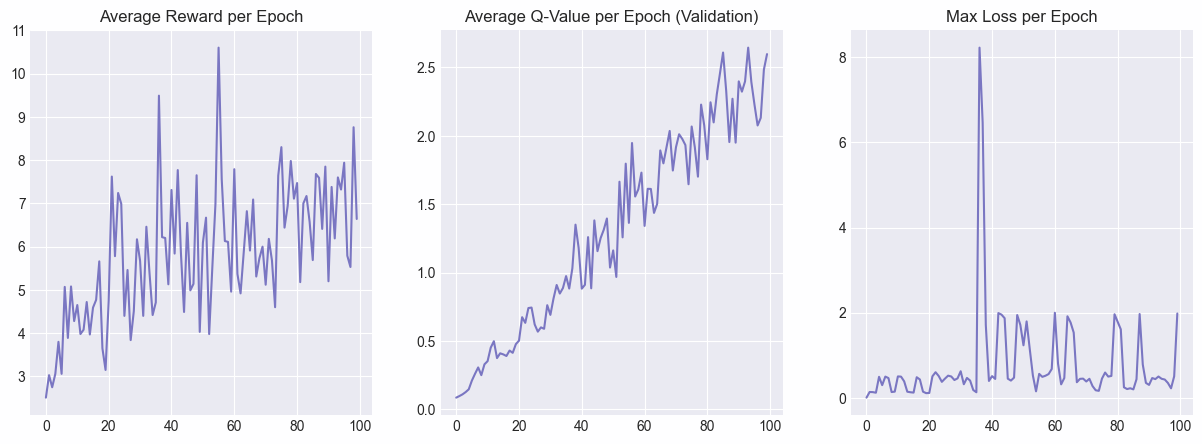

In [425]:
trained_policy_net_ft_er  = train_dqn_ft_er_agent(E=100, M=1000, gamma=0.99, epsilon_decay=0.9, lr=0.0001, 
                                                  optimizer_type="Adam", modification='dqn_ft_er_lr_0001')

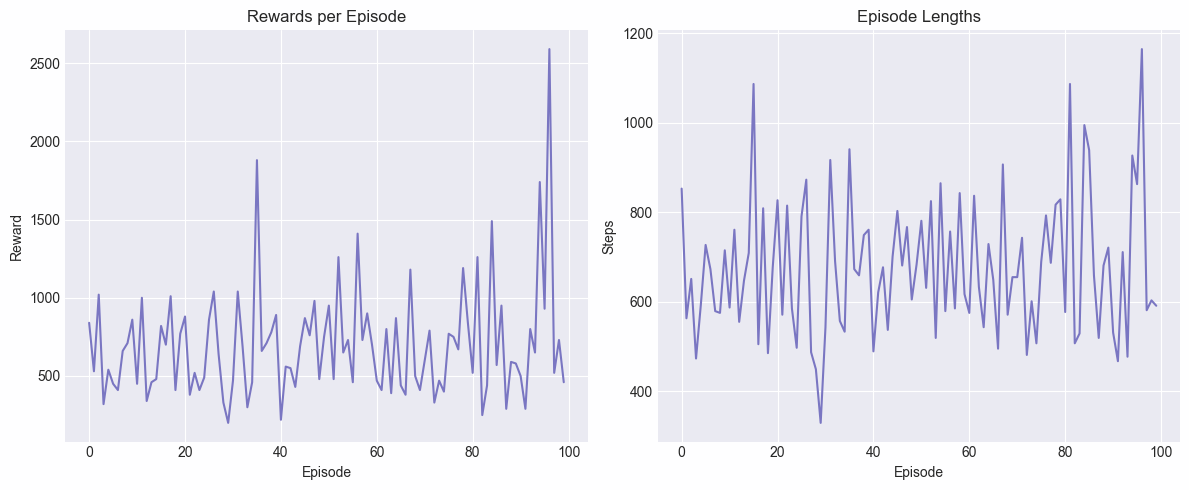

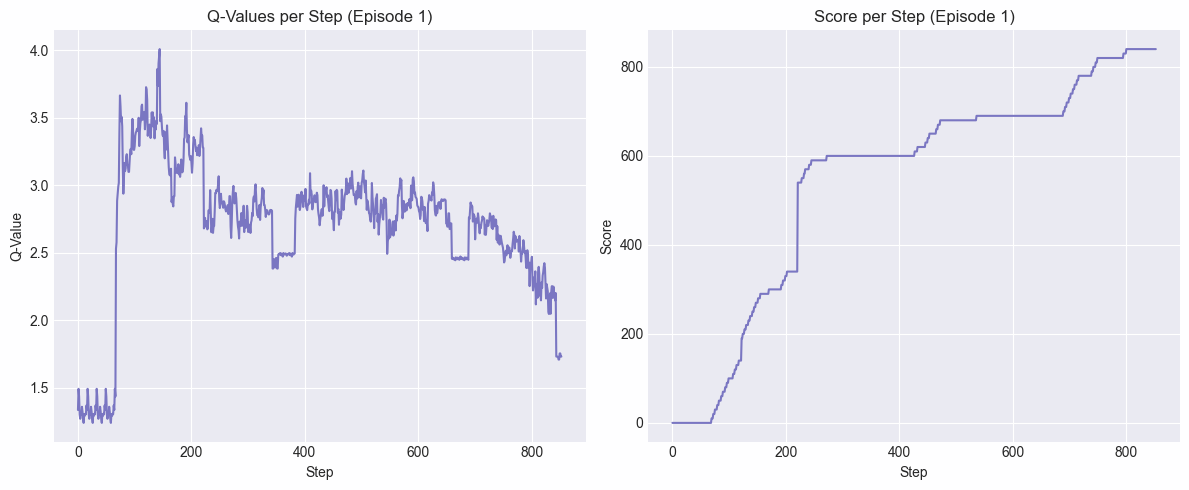

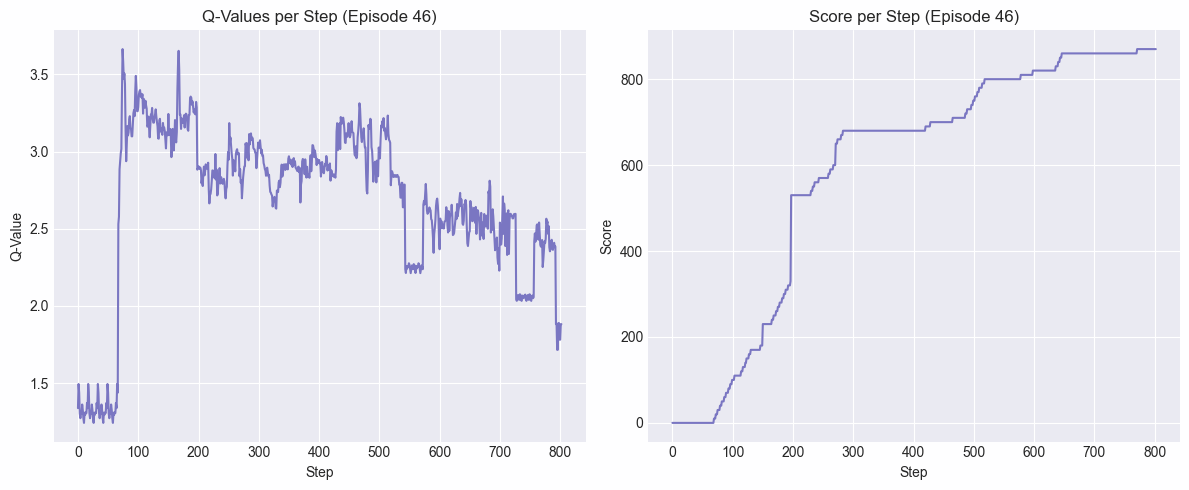

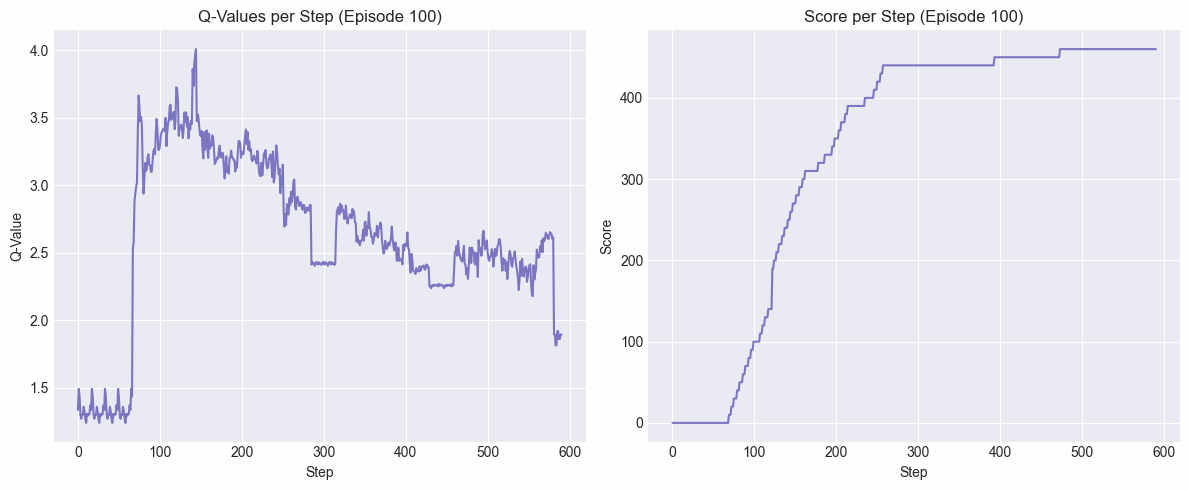

In [426]:
test_dqn_ft_er_agent("dqn_ft_er_lr_0001.pth", num_episodes=100)

## $\Delta\epsilon$

Epoch 1/100: Reward=2.29, Avg Q-Validation=0.05, Max Loss=0.0022
Epoch 2/100: Reward=2.64, Avg Q-Validation=0.06, Max Loss=0.0084
Epoch 3/100: Reward=2.43, Avg Q-Validation=0.07, Max Loss=0.0085
Epoch 4/100: Reward=2.92, Avg Q-Validation=0.08, Max Loss=0.0088
Epoch 5/100: Reward=2.65, Avg Q-Validation=0.08, Max Loss=0.0084
Epoch 6/100: Reward=2.88, Avg Q-Validation=0.10, Max Loss=0.1236
Epoch 7/100: Reward=3.31, Avg Q-Validation=0.12, Max Loss=0.1358
Epoch 8/100: Reward=4.36, Avg Q-Validation=0.11, Max Loss=0.5009
Epoch 9/100: Reward=2.93, Avg Q-Validation=0.14, Max Loss=0.4976
Epoch 10/100: Reward=3.84, Avg Q-Validation=0.17, Max Loss=0.4982
Epoch 11/100: Reward=6.23, Avg Q-Validation=0.16, Max Loss=1.9951
Epoch 12/100: Reward=3.56, Avg Q-Validation=0.22, Max Loss=2.0681
Epoch 13/100: Reward=4.46, Avg Q-Validation=0.19, Max Loss=1.9567
Epoch 14/100: Reward=3.77, Avg Q-Validation=0.20, Max Loss=0.4957
Epoch 15/100: Reward=3.47, Avg Q-Validation=0.23, Max Loss=0.4912
Epoch 16/100: Rewar

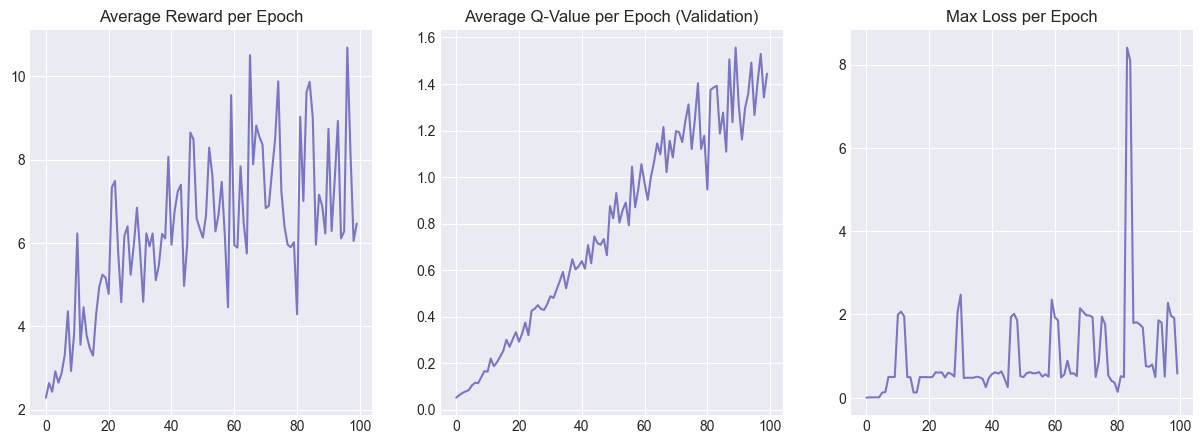

In [422]:
trained_policy_net_ft_er  = train_dqn_ft_er_agent(E=100, M=1000, gamma=0.99, epsilon_decay=0.95, lr=0.00001, 
                                                  optimizer_type="Adam", modification='dqn_ft_er_095decay')

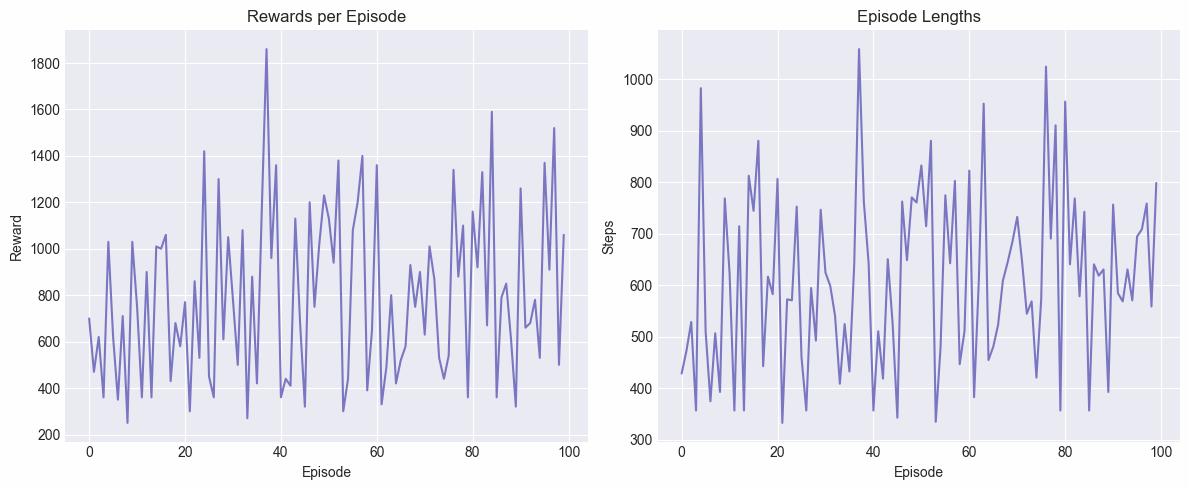

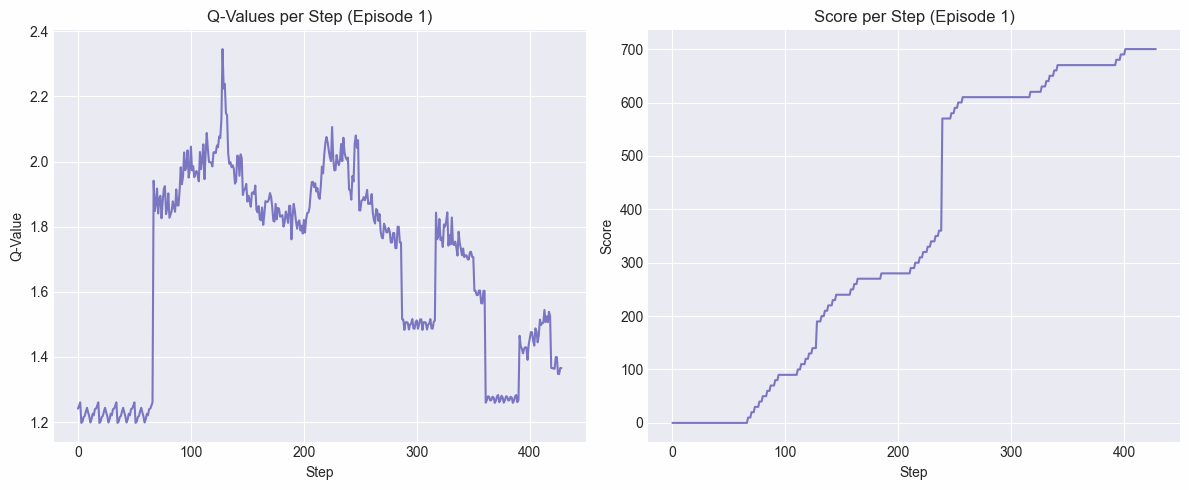

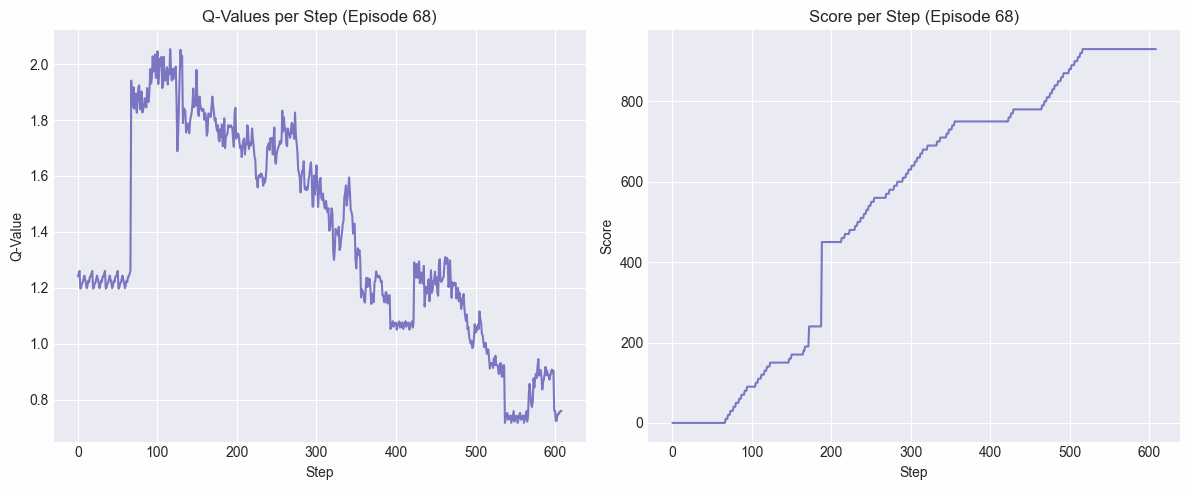

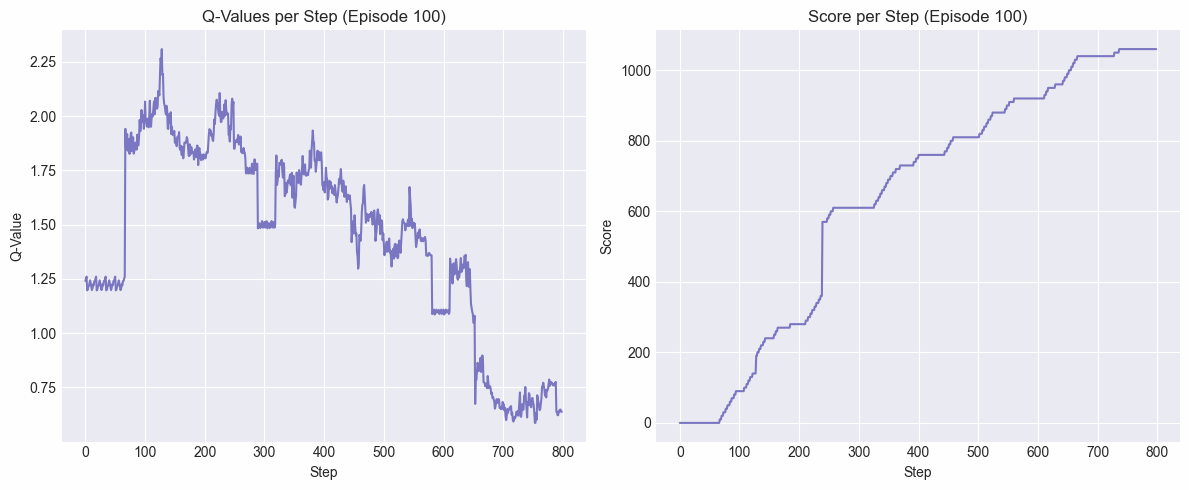

In [423]:
test_dqn_ft_er_agent("dqn_ft_er_095decay.pth", num_episodes=100)

In [454]:
def train_dqn_ft_er_agent_varC(env_name="ALE/MsPacman-v5", E=100, M=2000, gamma=0.99, epsilon_decay=0.995,
                               lr=0.0001, optimizer_type="Adam", buffer_size=10000, batch_size=32, K=1, C=10, modification='dqn_ft_er_pacman'):
    """
    Функція для тренування агента DQN-FT-ER з можливістю задавати частоту оновлення target_net через параметр C.
    
    Параметр C визначає кількість епізодів, після яких оновлюється target_net.
    """
    import random

    # Створення середовища
    env = gym.make(env_name)
    state_shape = (K, 84, 84)  # Вхідний стек із K кадрів
    num_actions = env.action_space.n

    # Ініціалізація політики та цільової мережі
    policy_net = DQN(state_shape, num_actions).to("cuda")
    target_net = DQN(state_shape, num_actions).to("cuda")
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=lr) if optimizer_type == "Adam" else optim.RMSprop(policy_net.parameters(), lr=lr)

    # Ініціалізація Experience Replay
    replay_buffer = deque(maxlen=buffer_size)

    # Ініціалізація стека кадрів
    frame_stack = FrameStack(K)

    epsilon = 1.0
    rewards_per_epoch = []
    q_values_per_epoch = []
    max_losses_per_epoch = []

    for epoch in range(E):
        total_reward = 0
        losses = []
        q_values = []

        for episode in range(M // E):
            initial_frame, _ = env.reset()
            state = frame_stack.reset(preprocess_frame(initial_frame).to("cuda"))
            done = False

            while not done:
                # Вибір дії
                if random.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    with torch.no_grad():
                        q_values_state = policy_net(state)
                        action = torch.argmax(q_values_state).item()

                # Виконання дії
                next_frame, reward, terminated, truncated, _ = env.step(action)
                reward /= 100
                next_state = frame_stack.step(preprocess_frame(next_frame).to("cuda"))

                # Збереження досвіду в буфер
                replay_buffer.append((state, action, reward, next_state, terminated or truncated))
                state = next_state
                total_reward += reward
                done = terminated or truncated

                # Повторюване навчання, якщо буфер достатньо заповнений
                if len(replay_buffer) >= batch_size:
                    minibatch = random.sample(replay_buffer, batch_size)
                    states, actions, rewards, next_states, dones = zip(*minibatch)

                    states = torch.cat(states).to("cuda")
                    actions = torch.tensor(actions, dtype=torch.long).to("cuda")
                    rewards = torch.tensor(rewards, dtype=torch.float32).to("cuda")
                    next_states = torch.cat(next_states).to("cuda")
                    dones = torch.tensor(dones, dtype=torch.float32).to("cuda")

                    # Обчислення поточних і цільових Q-значень з використанням target_net
                    current_q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze()
                    with torch.no_grad():
                        next_q_values = target_net(next_states).max(1)[0]
                    target_q_values = rewards + gamma * next_q_values * (1 - dones)

                    # Оновлення мережі
                    loss = F.mse_loss(current_q_values, target_q_values)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    losses.append(loss.item())

            # Оновлення параметрів target_net кожні C епізодів
            if (epoch * (M // E) + episode + 1) % C == 0:
                target_net.load_state_dict(policy_net.state_dict())

        # Зменшення epsilon
        epsilon = max(epsilon * epsilon_decay, 0.1)

        # Запис статистики
        max_loss = max(losses) if losses else 0
        rewards_per_epoch.append(total_reward / (M // E))
        max_losses_per_epoch.append(max_loss)

        # Валідаційний епізод
        initial_frame, _ = env.reset()
        state = frame_stack.reset(preprocess_frame(initial_frame).to("cuda"))
        done = False
        total_q_validation = 0
        steps = 0

        while not done:
            with torch.no_grad():
                q_values_validation = policy_net(state)
                total_q_validation += q_values_validation.max(1)[0].item()
                action = torch.argmax(q_values_validation).item()

            next_frame, _, terminated, truncated, _ = env.step(action)
            state = frame_stack.step(preprocess_frame(next_frame).to("cuda"))
            done = terminated or truncated
            steps += 1

        avg_q_validation = total_q_validation / steps if steps > 0 else 0
        q_values_per_epoch.append(avg_q_validation)

        print(f"Epoch {epoch+1}/{E}: Reward={rewards_per_epoch[-1]:.2f}, Avg Q-Validation={avg_q_validation:.2f}, Max Loss={max_loss:.4f}")

    # Збереження моделі
    model_save_path = f'{modification}.pth'
    torch.save(policy_net.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

    # Графіки
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(rewards_per_epoch)
    plt.title("Average Reward per Epoch")

    plt.subplot(1, 3, 2)
    plt.plot(q_values_per_epoch)
    plt.title("Average Q-Value per Epoch (Validation)")

    plt.subplot(1, 3, 3)
    plt.plot(max_losses_per_epoch)
    plt.title("Max Loss per Epoch")

    plt.show()

Epoch 1/100: Reward=2.53, Avg Q-Validation=0.09, Max Loss=0.0021
Epoch 2/100: Reward=2.79, Avg Q-Validation=0.12, Max Loss=0.1257
Epoch 3/100: Reward=2.60, Avg Q-Validation=0.15, Max Loss=0.1228
Epoch 4/100: Reward=2.62, Avg Q-Validation=0.21, Max Loss=0.1213
Epoch 5/100: Reward=2.90, Avg Q-Validation=0.27, Max Loss=0.0095
Epoch 6/100: Reward=3.83, Avg Q-Validation=0.31, Max Loss=0.1261
Epoch 7/100: Reward=3.44, Avg Q-Validation=0.34, Max Loss=0.1260
Epoch 8/100: Reward=6.28, Avg Q-Validation=0.41, Max Loss=0.6167
Epoch 9/100: Reward=4.77, Avg Q-Validation=0.36, Max Loss=0.4993
Epoch 10/100: Reward=4.72, Avg Q-Validation=0.48, Max Loss=0.4991
Epoch 11/100: Reward=4.29, Avg Q-Validation=0.49, Max Loss=0.4900
Epoch 12/100: Reward=7.04, Avg Q-Validation=0.61, Max Loss=0.4990
Epoch 13/100: Reward=5.23, Avg Q-Validation=0.70, Max Loss=0.5169
Epoch 14/100: Reward=4.70, Avg Q-Validation=0.72, Max Loss=0.3129
Epoch 15/100: Reward=7.20, Avg Q-Validation=0.70, Max Loss=1.9862
Epoch 16/100: Rewar

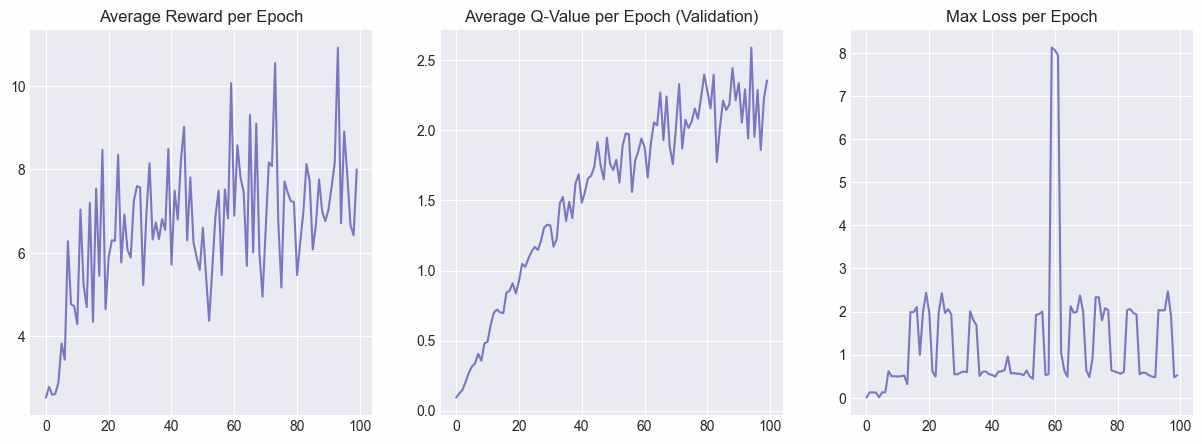

In [435]:
trained_policy_net_ft_er  = train_dqn_ft_er_agent_varC(E=100, M=1000, gamma=0.99, epsilon_decay=0.9, lr=0.00001, 
                                                  optimizer_type="Adam", modification='dqn_ft_er_C_3', C=3)

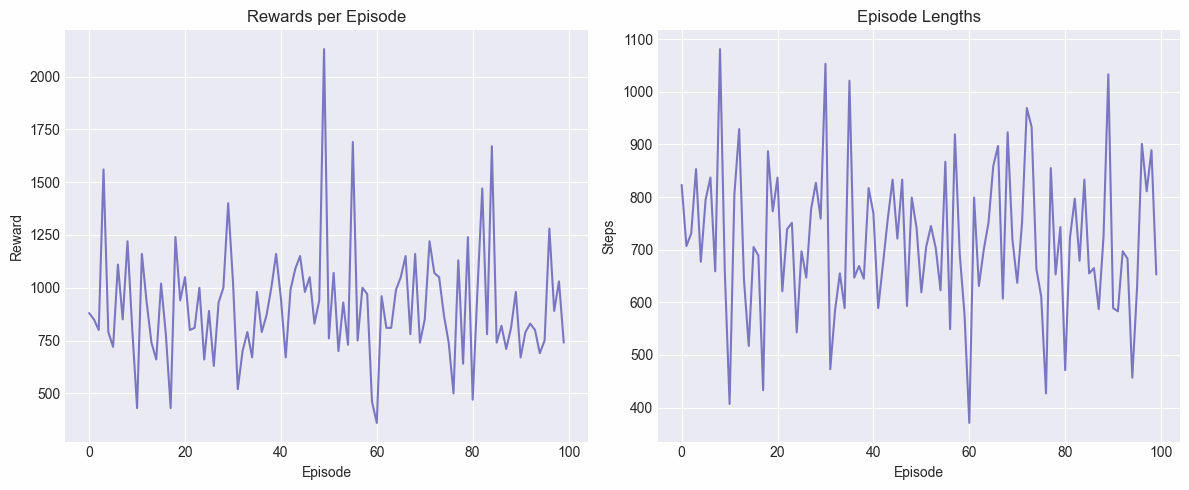

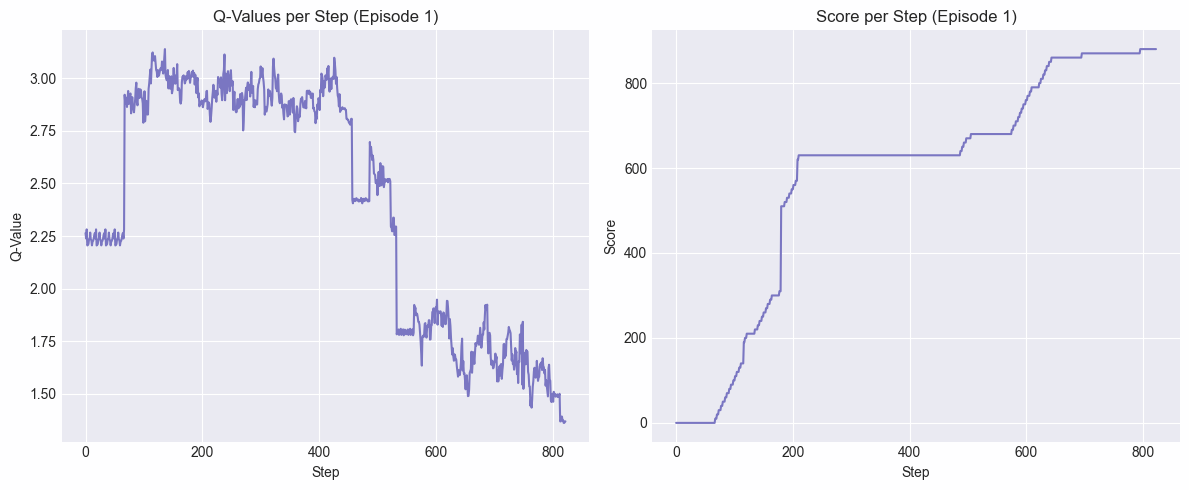

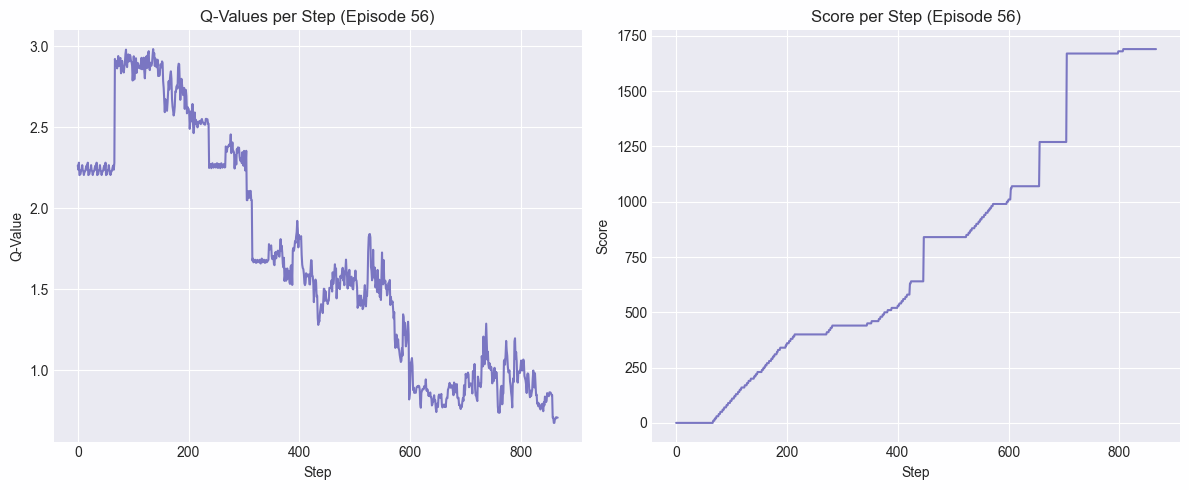

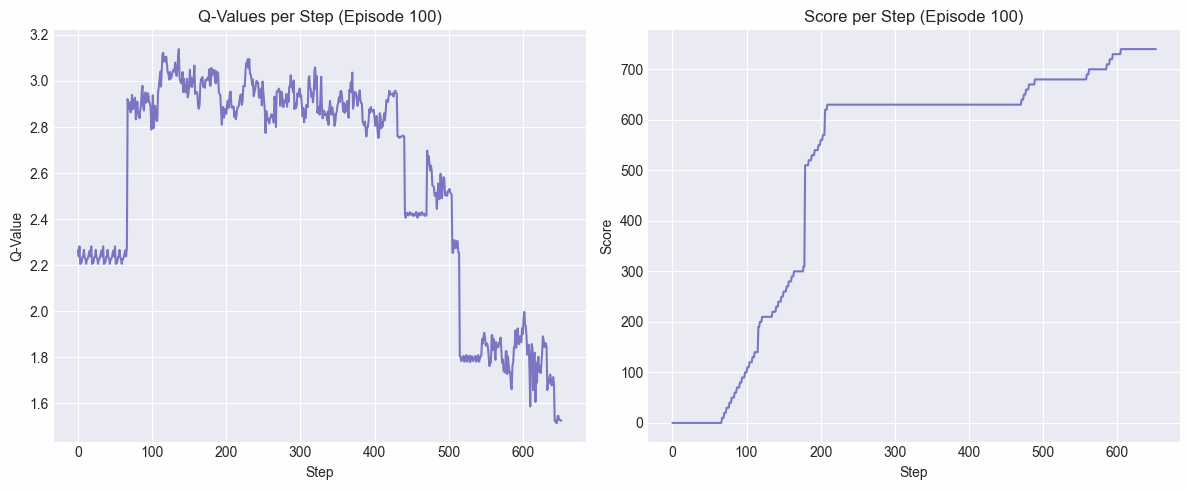

In [436]:
test_dqn_ft_er_agent("dqn_ft_er_C_3.pth", num_episodes=100)

## $\gamma$

Epoch 1/100: Reward=2.94, Avg Q-Validation=0.04, Max Loss=0.1303
Epoch 2/100: Reward=2.81, Avg Q-Validation=0.05, Max Loss=0.1230
Epoch 3/100: Reward=2.86, Avg Q-Validation=0.06, Max Loss=0.1197
Epoch 4/100: Reward=3.71, Avg Q-Validation=0.06, Max Loss=0.1247
Epoch 5/100: Reward=3.11, Avg Q-Validation=0.07, Max Loss=0.1270
Epoch 6/100: Reward=3.70, Avg Q-Validation=0.09, Max Loss=0.4980
Epoch 7/100: Reward=4.00, Avg Q-Validation=0.10, Max Loss=0.4971
Epoch 8/100: Reward=3.78, Avg Q-Validation=0.09, Max Loss=0.4899
Epoch 9/100: Reward=4.17, Avg Q-Validation=0.12, Max Loss=0.1309
Epoch 10/100: Reward=3.87, Avg Q-Validation=0.11, Max Loss=0.2407
Epoch 11/100: Reward=3.44, Avg Q-Validation=0.11, Max Loss=0.2389
Epoch 12/100: Reward=4.03, Avg Q-Validation=0.12, Max Loss=0.1239
Epoch 13/100: Reward=4.48, Avg Q-Validation=0.11, Max Loss=0.1242
Epoch 14/100: Reward=6.20, Avg Q-Validation=0.12, Max Loss=0.5000
Epoch 15/100: Reward=5.26, Avg Q-Validation=0.12, Max Loss=0.4988
Epoch 16/100: Rewar

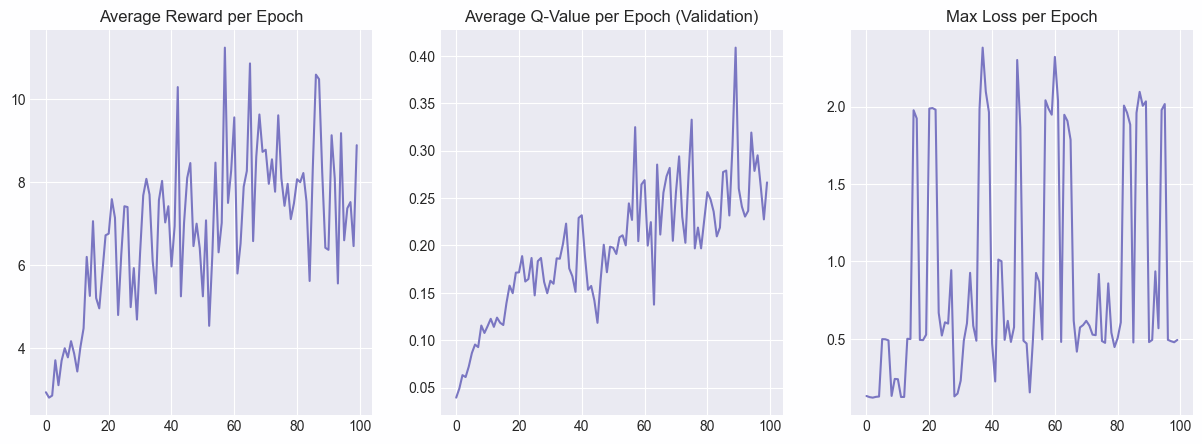

In [429]:
trained_policy_net_ft_er  = train_dqn_ft_er_agent(E=100, M=1000, gamma=0.9, epsilon_decay=0.9, lr=0.00001, 
                                                  optimizer_type="Adam", modification='dqn_ft_er_gamma_09')

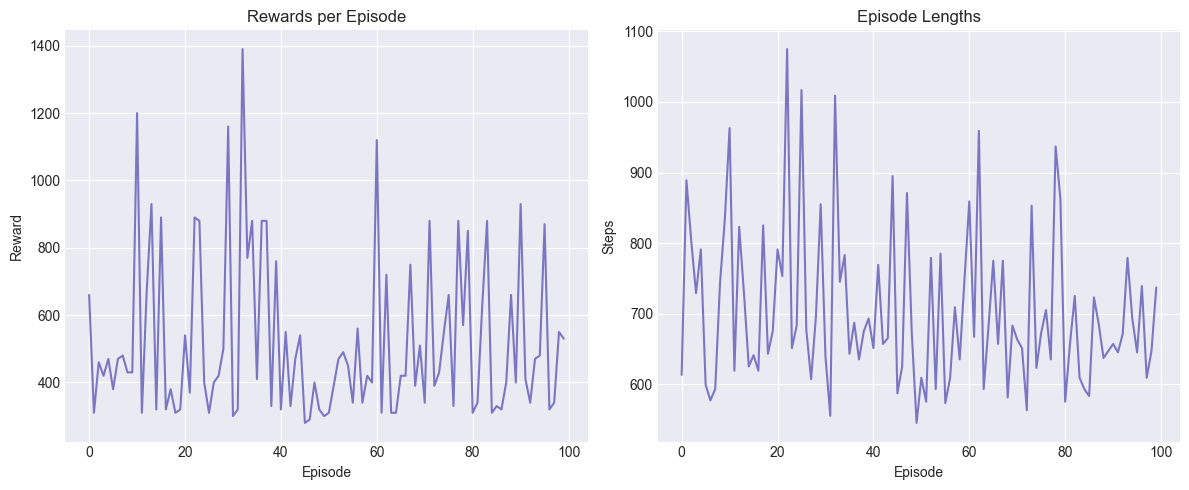

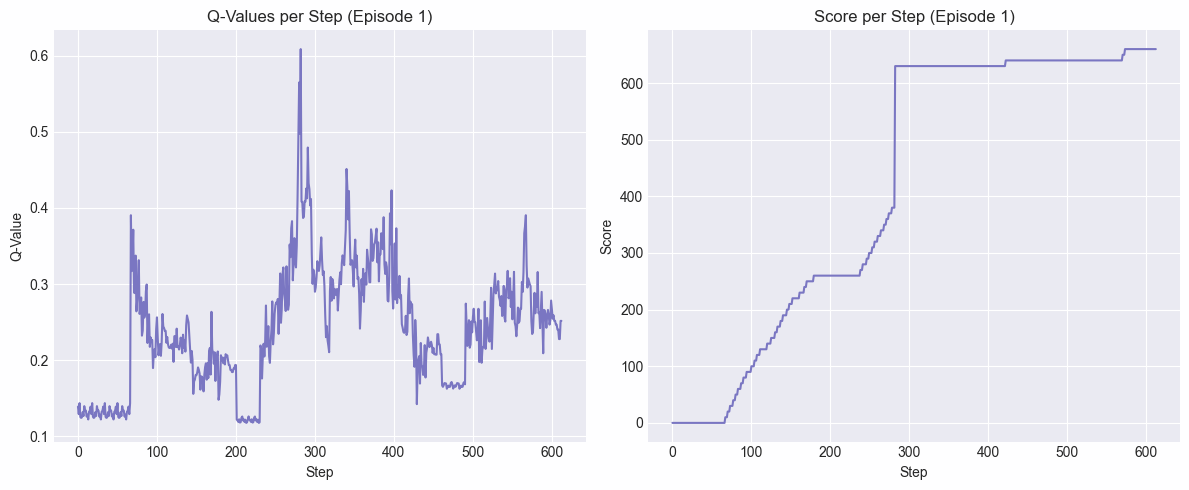

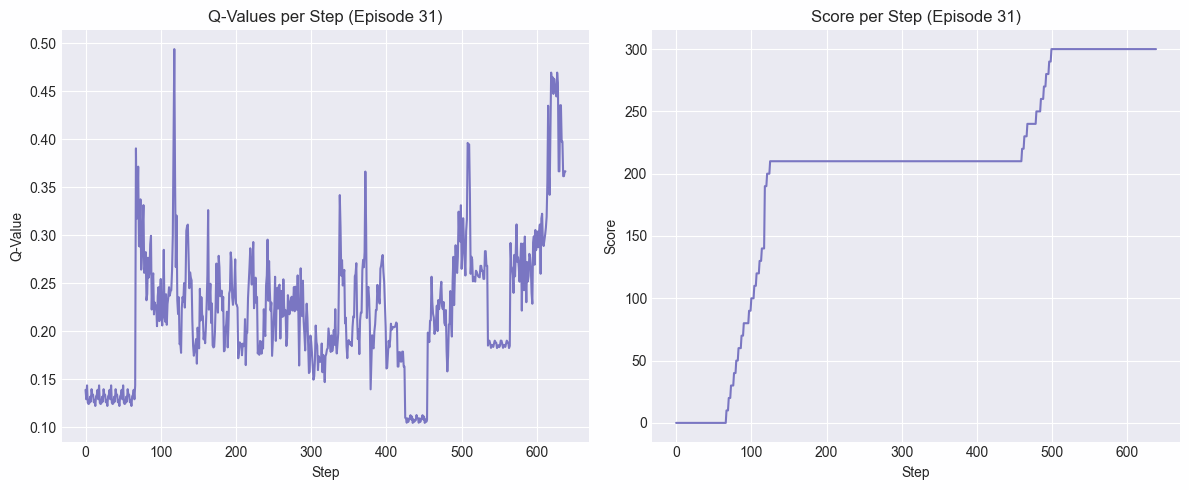

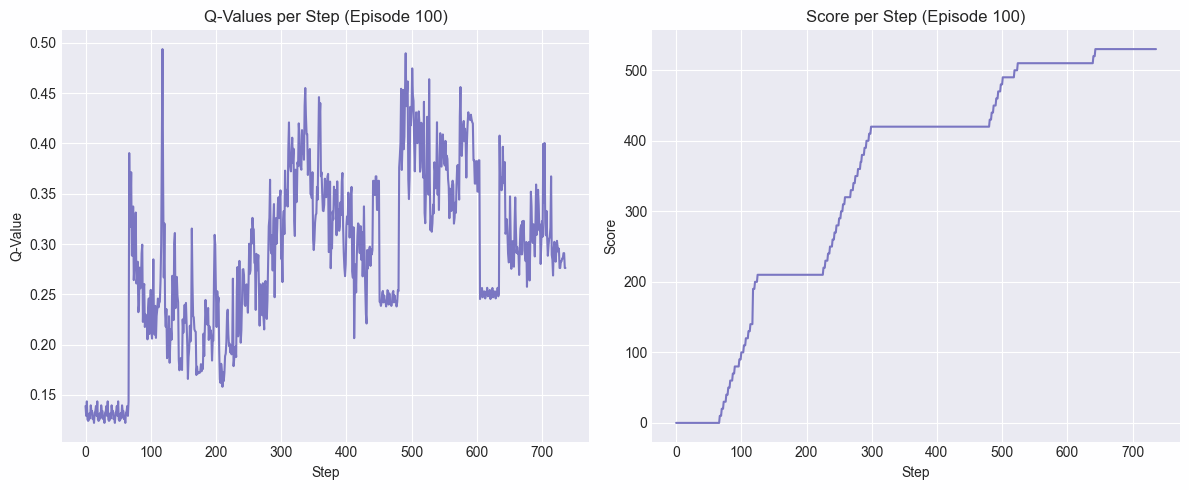

In [430]:
test_dqn_ft_er_agent("dqn_ft_er_gamma_09.pth", num_episodes=100)

#### 12. Для моделі DQN-FT-ER повторити завдання 3, 4, дослідивши вплив зміни гіперпараметрів нейронної мережі, які стосуються її структури, на навчання і якість прогнозування. Можливі сценарії:
> #### a. зміна кількості нейронів на деяких або усіх шарах;
> #### b. зміна кількості шарів;
> #### c. зміна функцій активації на деяких або усіх шарах;
> #### d. зміна параметрів згорткових шарів (розмір згортки (kernel size), крок фільтру по матриці (stride), кількість нулів навколо граничного пікселя (padding));
> #### e. зміна типу для деяких або усіх активаційних шарів.

In [511]:
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc = nn.Linear(7 * 7 * 64, 512)
        self.out = nn.Linear(512, n_actions)

        # Параметр для LeakyReLU
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        x = self.leaky_relu(self.conv1(x))
        x = self.leaky_relu(self.conv2(x))
        x = self.leaky_relu(self.conv3(x))
        x = x.view(x.size(0), -1)   # Flatten тензора
        x = self.leaky_relu(self.fc(x))
        return self.out(x)

In [512]:
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha):
        self.capacity = capacity
        self.alpha = alpha
        self.buffer = []
        self.priorities = []
        self.position = 0

    def add(self, experience, priority):
        max_priority = max(self.priorities, default=1.0)
        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
            self.priorities.append(priority if priority else max_priority)
        else:
            self.buffer[self.position] = experience
            self.priorities[self.position] = priority if priority else max_priority
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size, beta):
        priorities = np.array(self.priorities) ** self.alpha
        probabilities = priorities / priorities.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=probabilities)
        samples = [self.buffer[i] for i in indices]

        weights = (len(self.buffer) * probabilities[indices]) ** (-beta)
        weights /= weights.max()

        return samples, indices, torch.FloatTensor(weights)

    def update_priorities(self, indices, priorities):
        for i, priority in zip(indices, priorities):
            self.priorities[i] = priority

In [522]:
def train_ddqn_ft_per_agent(env_name="ALE/MsPacman-v5", E=100, M=2000, gamma=0.99, epsilon_decay=0.995,
                            lr=0.0001, optimizer_type="Adam", buffer_size=10000, batch_size=32,
                            K=4, C=10, alpha=0.6, beta_start=0.4, beta_increment=0.001, modification='ddqn_per'):
    """
    Функція для навчання Double DQN з fixed targets і prioritized experience replay (PER), 
    адаптована для використання класу FrameStack.
    """
    import random

    # Створення середовища
    env = gym.make(env_name)
    state_shape = (K, 84, 84)  # Вхідний стек із K кадрів
    num_actions = env.action_space.n

    # Ініціалізація політики та цільової мережі
    policy_net = DQN(state_shape, num_actions).to("cuda")
    target_net = DQN(state_shape, num_actions).to("cuda")
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=lr) if optimizer_type == "Adam" else optim.RMSprop(policy_net.parameters(), lr=lr)

    # Ініціалізація PER buffer
    replay_buffer = PrioritizedReplayBuffer(buffer_size, alpha)

    # Ініціалізація стека кадрів
    frame_stack = FrameStack(K)

    epsilon = 1.0
    beta = beta_start
    rewards_per_epoch = []
    q_values_per_epoch = []
    max_losses_per_epoch = []

    for epoch in range(E):
        total_reward = 0
        losses = []

        for episode in range(M // E):
            initial_frame, _ = env.reset()
            state = frame_stack.reset(preprocess_frame(initial_frame).to("cuda"))
            done = False

            while not done:
                # Вибір дії
                if random.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    with torch.no_grad():
                        q_values_state = policy_net(state)
                        action = torch.argmax(q_values_state).item()

                # Виконання дії
                next_frame, reward, terminated, truncated, _ = env.step(action)
                reward /= 100
                next_state = frame_stack.step(preprocess_frame(next_frame).to("cuda"))

                # Розрахунок пріоритету для нового досвіду
                with torch.no_grad():
                    next_q = target_net(next_state).max(1)[0].item()
                    td_error = abs(reward + gamma * next_q - policy_net(state)[0, action].item())
                priority = (td_error + 1e-5) ** alpha

                # Додавання досвіду в буфер
                replay_buffer.add((state, action, reward, next_state, terminated or truncated), priority)
                state = next_state
                total_reward += reward
                done = terminated or truncated

                # Повторюване навчання, якщо буфер достатньо заповнений
                if len(replay_buffer.buffer) >= batch_size:
                    samples, indices, weights = replay_buffer.sample(batch_size, beta)
                    states, actions, rewards, next_states, dones = zip(*samples)

                    states = torch.cat(states).to("cuda")
                    actions = torch.tensor(actions, dtype=torch.long).to("cuda")
                    rewards = torch.tensor(rewards, dtype=torch.float32).to("cuda")
                    next_states = torch.cat(next_states).to("cuda")
                    dones = torch.tensor(dones, dtype=torch.float32).to("cuda")
                    weights = weights.to("cuda")

                    # Обчислення поточних і цільових Q-значень
                    current_q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze()
                    with torch.no_grad():
                        next_actions = policy_net(next_states).argmax(1)
                        next_q_values = target_net(next_states).gather(1, next_actions.unsqueeze(1)).squeeze()
                        target_q_values = rewards + gamma * next_q_values * (1 - dones)

                    # Оновлення мережі
                    loss = (F.mse_loss(current_q_values, target_q_values, reduction='none') * weights).mean()
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    # Оновлення пріоритетів
                    td_errors = abs(current_q_values - target_q_values).detach().cpu().numpy()
                    replay_buffer.update_priorities(indices, td_errors)

                    losses.append(loss.item())

            # Оновлення target_net кожні C епізодів
            if (epoch * (M // E) + episode + 1) % C == 0:
                target_net.load_state_dict(policy_net.state_dict())

        # Зменшення epsilon
        epsilon = max(epsilon * epsilon_decay, 0.1)

        # Збільшення beta
        beta = min(beta + beta_increment, 1.0)

        # Запис статистики
        max_loss = max(losses) if losses else 0
        rewards_per_epoch.append(total_reward / (M // E))
        max_losses_per_epoch.append(max_loss)

        print(f"Epoch {epoch+1}/{E}: Reward={rewards_per_epoch[-1]:.2f}, Max Loss={max_loss:.4f}")

    # Збереження моделі
    model_save_path = f'{modification}.pth'
    torch.save(policy_net.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

    return policy_net


In [525]:
trained_policy_net_ddqn_per = train_ddqn_ft_per_agent(
    env_name="ALE/MsPacman-v5",  # Середовище
    E=100,                       # Кількість епох
    M=1000,                      # Кількість епізодів
    gamma=0.99,                  # Дисконтний фактор
    epsilon_decay=0.9,           # Зменшення epsilon
    lr=0.00001,                  # Швидкість навчання
    optimizer_type="Adam",       # Оптимізатор
    buffer_size=10000,           # Розмір буферу
    batch_size=32,               # Розмір батчу
    K=1,                         # Кількість кадрів у стеку
    C=3,                         # Кількість епізодів для оновлення target_net
    alpha=0.6,                   # Параметр для PER
    beta_start=0.4,              # Початкове значення beta для PER
    beta_increment=0.001,        # Збільшення beta для PER
    modification='ddqn_per'      # Назва моделі для збереження
)

Epoch 1/100: Reward=2.18, Max Loss=0.0017
Epoch 2/100: Reward=2.70, Max Loss=0.0535
Epoch 3/100: Reward=2.62, Max Loss=0.0343
Epoch 4/100: Reward=2.92, Max Loss=0.0438
Epoch 5/100: Reward=3.25, Max Loss=0.0591
Epoch 6/100: Reward=3.21, Max Loss=0.0739
Epoch 7/100: Reward=3.46, Max Loss=0.0396
Epoch 8/100: Reward=3.19, Max Loss=0.0262
Epoch 9/100: Reward=3.81, Max Loss=0.0252
Epoch 10/100: Reward=4.07, Max Loss=0.0486
Epoch 11/100: Reward=3.66, Max Loss=0.0395
Epoch 12/100: Reward=3.98, Max Loss=0.0574
Epoch 13/100: Reward=5.93, Max Loss=0.0813
Epoch 14/100: Reward=4.11, Max Loss=0.2625
Epoch 15/100: Reward=5.56, Max Loss=0.2730
Epoch 16/100: Reward=4.60, Max Loss=0.2837
Epoch 17/100: Reward=5.02, Max Loss=0.2044
Epoch 18/100: Reward=4.24, Max Loss=0.2322
Epoch 19/100: Reward=5.62, Max Loss=0.2435
Epoch 20/100: Reward=5.74, Max Loss=0.1927
Epoch 21/100: Reward=5.64, Max Loss=0.2481
Epoch 22/100: Reward=5.58, Max Loss=0.1996
Epoch 23/100: Reward=7.13, Max Loss=0.4084
Epoch 24/100: Reward

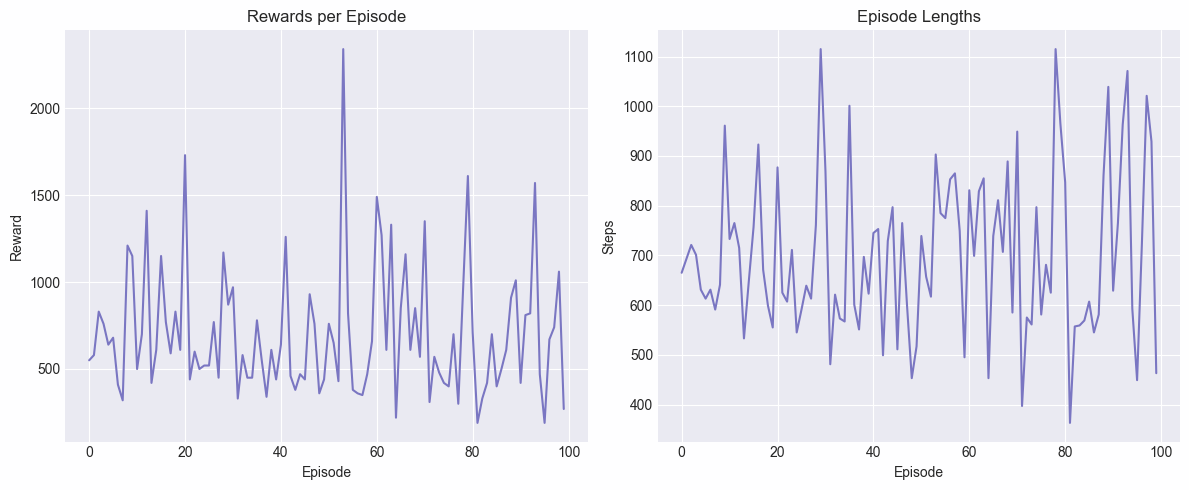

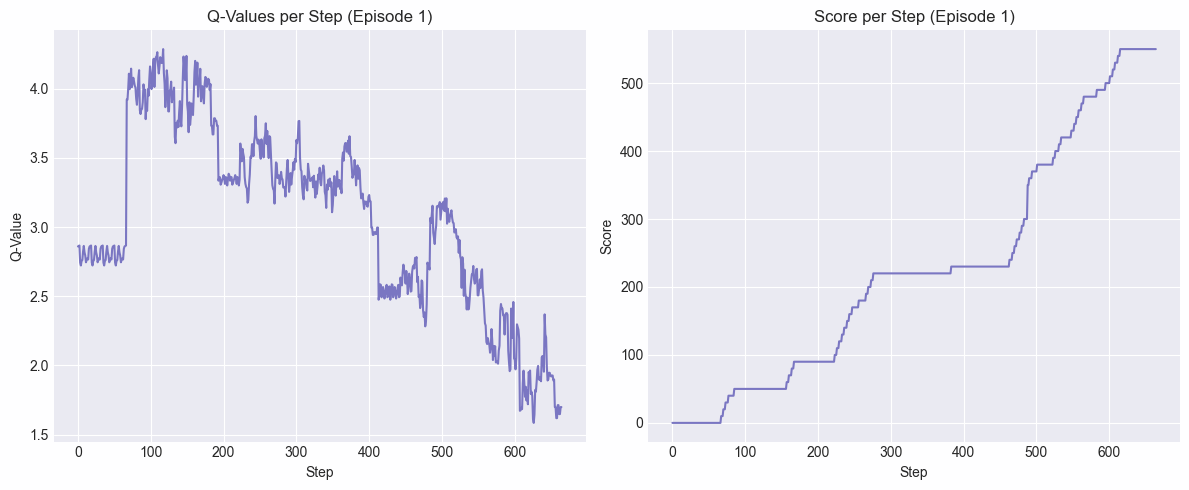

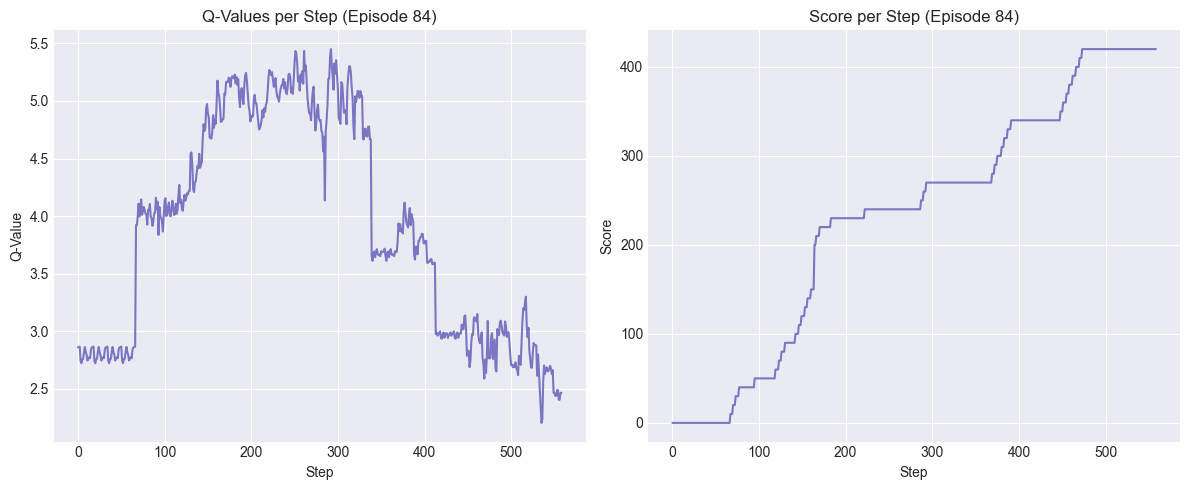

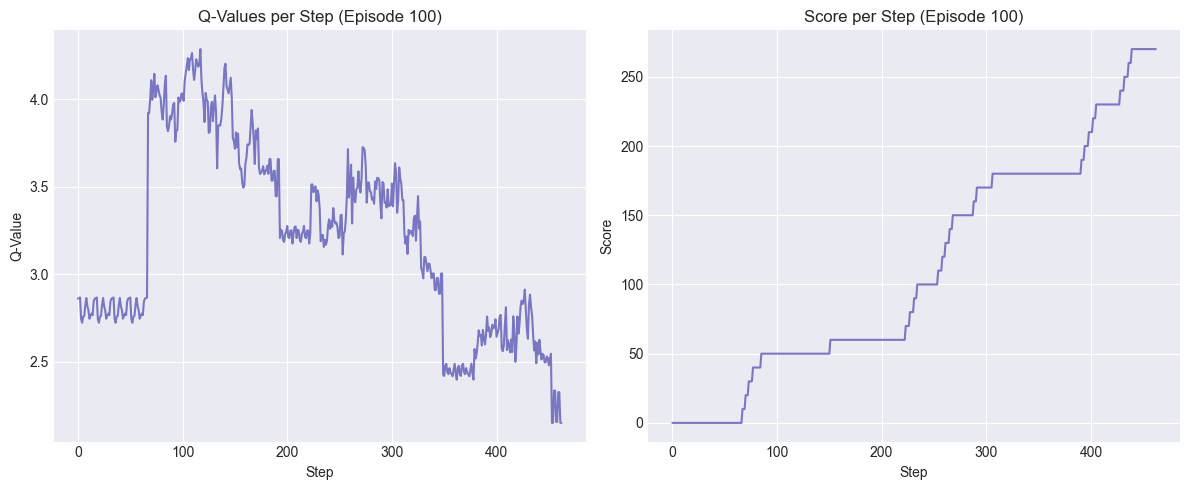

In [526]:
test_dqn_ft_er_agent("ddqn_per.pth", num_episodes=100)

### ДОДАТКОВО

In [366]:
def test_dqn_ft_er_agent_with_video(model_path, env_name="ALE/MsPacman-v5", num_episodes=100, video_dir="./pacman_videos"):
    """
    Тестування агента DQN-FT-ER з записом відео.
    """
    from gym.wrappers import RecordVideo

    # Завантаження середовища з режимом `rgb_array`
    env = gym.make(env_name, render_mode="rgb_array")
    env = RecordVideo(env, video_dir, episode_trigger=lambda episode_id: True)

    state_shape = (1, 84, 84)  # Грейскейл зображення 84x84
    num_actions = env.action_space.n

    # Завантаження політики
    policy_net = DQN(state_shape, num_actions).to("cuda")
    policy_net.load_state_dict(torch.load(model_path, weights_only=True))
    policy_net.eval()

    episode_rewards = []
    episode_lengths = []

    q_values_data = {}
    scores_data = {}

    # Випадковий епізод
    random_episode = random.randint(1, num_episodes)

    for episode in range(1, num_episodes + 1):
        state, _ = env.reset()
        state = preprocess_frame(state)
        state = torch.FloatTensor(state).unsqueeze(0).to("cuda")
        done = False

        total_reward = 0
        steps = 0

        q_values = []
        scores = []

        while not done:
            with torch.no_grad():
                # Вибір дії
                q_values_state = policy_net(state)
                action = torch.argmax(q_values_state).item()

            # Виконання дії
            next_state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward

            # Збереження Q-Values і Score
            q_values.append(q_values_state.max(1)[0].item())
            scores.append(total_reward)

            # Перехід до наступного стану
            next_state = preprocess_frame(next_state)
            state = torch.FloatTensor(next_state).unsqueeze(0).to("cuda")

            done = terminated or truncated
            steps += 1

        # Збереження результатів епізоду
        episode_rewards.append(total_reward)
        episode_lengths.append(steps)

        # Збереження даних для епізодів 1, random_episode, 100
        if episode in {1, random_episode, num_episodes}:
            q_values_data[episode] = q_values
            scores_data[episode] = scores

    # Графіки винагород і тривалості епізодів
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(episode_rewards)
    plt.title("Rewards per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Reward")

    plt.subplot(1, 2, 2)
    plt.plot(episode_lengths)
    plt.title("Episode Lengths")
    plt.xlabel("Episode")
    plt.ylabel("Steps")

    plt.tight_layout()
    plt.show()

    # Графіки Q-Values і Score для епізодів 1, random_episode, 100
    for episode in [1, random_episode, num_episodes]:
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(q_values_data[episode])
        plt.title(f"Q-Values per Step (Episode {episode})")
        plt.xlabel("Step")
        plt.ylabel("Q-Value")

        plt.subplot(1, 2, 2)
        plt.plot(scores_data[episode])
        plt.title(f"Score per Step (Episode {episode})")
        plt.xlabel("Step")
        plt.ylabel("Score")

        plt.tight_layout()
        plt.show()

    env.close()

C:\Users\alexa\anaconda3\lib\site-packages\gym\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-0.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-0.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-1.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-1.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-1.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-2.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-2.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-2.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-3.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-3.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-3.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-4.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-4.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-4.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-5.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-5.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-5.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-6.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-6.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-6.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-7.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-7.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-7.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-8.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-8.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-8.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-9.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-9.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-9.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-10.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-10.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-10.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-11.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-11.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-11.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-12.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-12.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-12.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-13.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-13.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-13.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-14.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-14.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-14.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-15.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-15.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-15.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-16.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-16.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-16.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-17.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-17.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-17.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-18.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-18.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-18.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-19.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-19.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-19.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-20.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-20.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-20.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-21.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-21.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-21.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-22.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-22.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-22.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-23.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-23.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-23.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-24.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-24.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-24.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-25.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-25.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-25.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-26.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-26.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-26.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-27.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-27.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-27.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-28.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-28.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-28.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-29.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-29.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-29.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-30.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-30.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-30.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-31.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-31.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-31.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-32.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-32.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-32.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-33.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-33.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-33.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-34.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-34.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-34.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-35.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-35.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-35.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-36.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-36.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-36.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-37.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-37.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-37.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-38.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-38.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-38.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-39.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-39.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-39.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-40.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-40.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-40.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-41.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-41.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-41.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-42.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-42.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-42.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-43.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-43.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-43.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-44.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-44.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-44.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-45.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-45.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-45.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-46.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-46.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-46.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-47.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-47.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-47.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-48.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-48.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-48.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-49.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-49.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-49.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-50.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-50.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-50.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-51.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-51.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-51.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-52.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-52.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-52.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-53.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-53.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-53.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-54.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-54.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-54.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-55.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-55.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-55.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-56.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-56.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-56.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-57.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-57.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-57.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-58.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-58.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-58.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-59.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-59.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-59.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-60.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-60.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-60.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-61.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-61.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-61.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-62.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-62.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-62.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-63.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-63.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-63.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-64.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-64.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-64.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-65.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-65.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-65.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-66.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-66.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-66.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-67.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-67.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-67.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-68.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-68.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-68.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-69.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-69.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-69.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-70.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-70.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-70.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-71.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-71.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-71.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-72.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-72.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-72.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-73.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-73.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-73.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-74.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-74.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-74.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-75.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-75.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-75.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-76.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-76.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-76.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-77.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-77.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-77.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-78.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-78.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-78.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-79.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-79.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-79.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-80.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-80.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-80.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-81.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-81.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-81.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-82.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-82.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-82.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-83.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-83.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-83.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-84.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-84.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-84.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-85.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-85.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-85.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-86.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-86.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-86.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-87.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-87.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-87.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-88.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-88.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-88.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-89.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-89.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-89.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-90.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-90.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-90.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-91.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-91.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-91.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-92.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-92.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-92.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-93.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-93.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-93.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-94.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-94.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-94.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-95.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-95.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-95.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-96.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-96.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-96.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-97.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-97.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-97.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-98.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-98.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-98.mp4
MoviePy - Building video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-99.mp4.
MoviePy - Writing video C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-99.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\alexa\Deep RL\ЛР№2\pacman_videos_20241224_172028\rl-video-episode-99.mp4


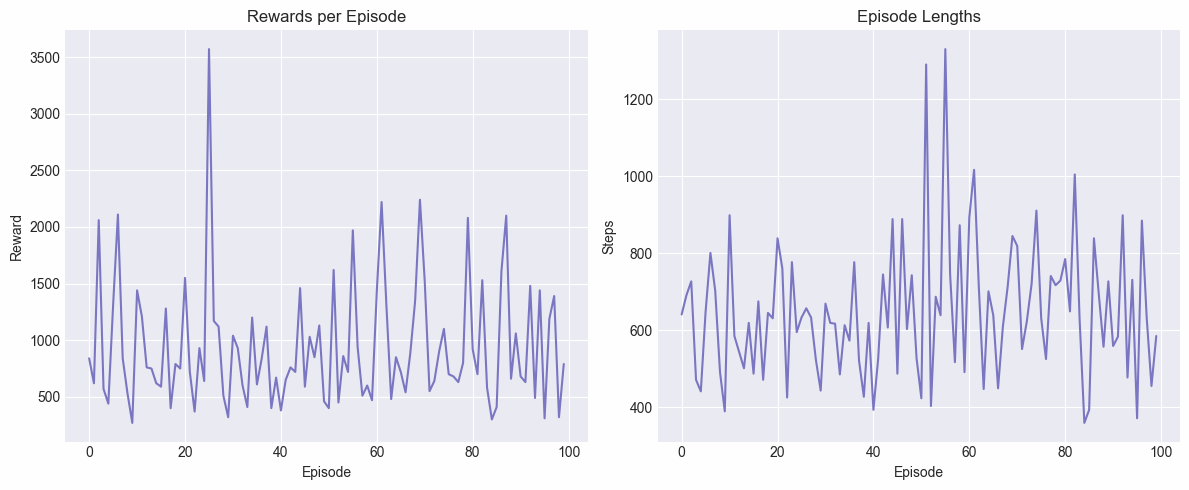

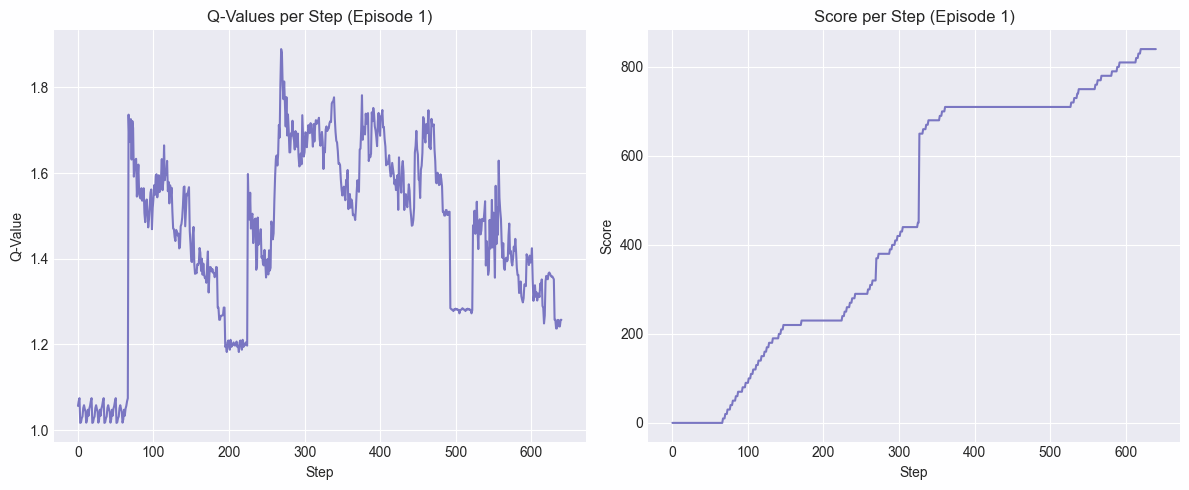

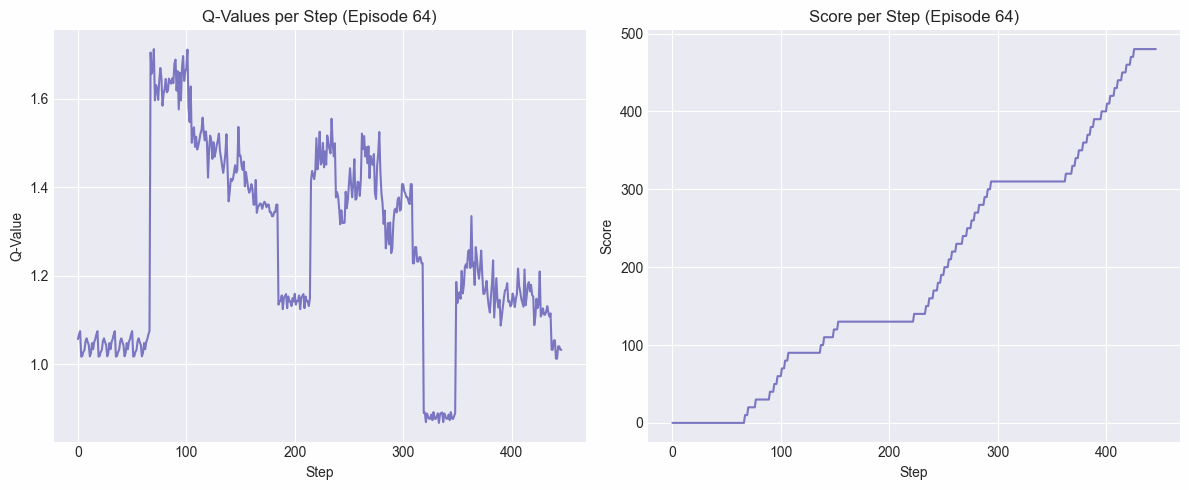

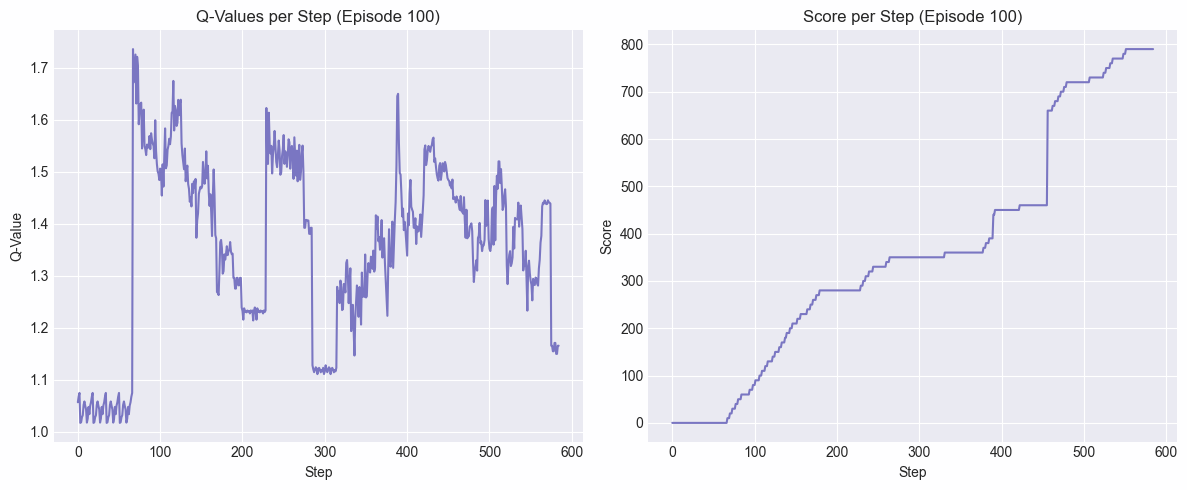

In [368]:
# Генерація унікальної назви папки
unique_video_dir = f"./pacman_videos_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}"

if not os.path.exists(unique_video_dir):
    os.makedirs(unique_video_dir)

# Виклик функції з новою папкою
test_dqn_ft_er_agent_with_video("dqn_ft_er_pacman.pth", video_dir=unique_video_dir)